# Proyecto Curso

Desarrollo del proyecto Final para el Curso de Statistical Learning -  Segundo Trimestre Maestria en Ciencia de Datos- Universidad Galileo.

Este Notebook en específico servirá el Deployment de Modelos ya entrenados para la predicción del Problema "Predicción de Supervivencia Titanic". En un Notebook diferente se hizo el Entrenamiento/Validación de los modelos que aquí se usaran para la predicción.

In [67]:
##Referencia a Librerias que usaremos en este notebook
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn import tree
import pandas as pd
from scipy import stats

## Cargamos los Modelos Entrenados

Los modelos entrenados y definidos en el notebook anterior, se cargaran.

Enlace Notebook donde se implementan los modelos:
https://github.com/jonathanDeLeonGES/jupyterNotebooks/blob/master/Proyecto%20Statistical%20Learning/Proyecto%20-%20Titanic%20-%20Modelos.ipynb

### 1. Modelo - DecisionTree 

In [4]:
##Tomamos el Clasificador con mejores resultados
DT_Classifier = pickle.load( open( "DumpDT/20200629_225218_DecisionTree_max_depth=5.p", "rb" ) )
DT_Classifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

### 2. Modelo - SVM (Support Vector Machine) 

In [5]:
##Tomamos el Clasificador con mejores resultados
SVM_Classifier = pickle.load( open( "DumpSVM/20200629_225241_SVM_random_state=None_tol=0.001_C=1_degree=3_max_iter=-1.p", "rb" ) )
SVM_Classifier

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 3. Modelo - Naive Bayes

In [15]:
##Tomamos el Clasificador con mejores resultados
NB_Classifier = pickle.load( open( "DumpNB/20200629_195113_NaiveBayes_alpha=1.p", "rb" ) )
NB_Classifier

### 4. Modelo - Regresión Logistica

In [11]:
##Tomamos el Clasificador con mejores resultados
RL_Weights = np.load("DumpRL/20200629_225424_MiniBatch_GD_Lr=0.1_reg=0.01_reg_Type=L2_BatchSize=50.npy",allow_pickle=True)
RL_Weights

array([[-0.4022264 ],
       [-0.27672705],
       [-0.04158774],
       [ 0.16427359],
       [-1.1317778 ],
       [ 0.0348492 ],
       [-0.01437835],
       [-0.11370662],
       [-0.4203568 ],
       [ 0.03524392],
       [ 0.45458624]], dtype=float32)

Implementamos de una vez, la función de predicción para el modelo con Regresión logistica, ya que a diferencia de los otros, este no cuenta aún con su función de predicción.

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predicciónRL(weights,x):
    '''Defimos función generico para la predicción de la Regresión Logistica'''
    #Determinamos los logits
    logits= np.matmul(x, weights)
    #Determinamos la predicción con Sigmoid
    predict = np.round(sigmoid(logits))
    ##Retornamos la predicción
    return predict

## Normalización de los Datos

Cargaremos los objetos(scalers) que nos servirán para transformar/Normalizar la data que vamos a buscar predecir.

In [20]:
##Cargamos el Normalizador Standar
Standar_Scaler = pickle.load( open( "DumpScalers/StandarScaler.p", "rb" ) )
Standar_Scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
##Cargamos el Normalizador MinMax
MinMax_Scaler = pickle.load( open( "DumpScalers/MinMaxScaler.p", "rb" ) )
MinMax_Scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

## Función de Predicción - Solo una Observación

Crearemos la función para la predicción de una sola observación, combinando los modelos que ya cargamos.

In [98]:
def prediccionObservacion(x):
    
    #Antes de Cualquier cosa - Se normalizará la observación
    #Standard
    x_st = Standar_Scaler.transform(x)
    #MinMax -> Funciona mejor para Naive Bayes
    x_mm = MinMax_Scaler.transform(x)
    #Predicción Sobre la observacion - DecisionTree 
    y_pred_test_DT = DT_Classifier.predict(x_st)
    #Predicción Sobre la observacion - SVM
    y_pred_test_SVM = SVM_Classifier.predict(x_st)
    #Predicción Sobre la observacion - NB
    y_pred_test_NB = NB_Classifier.predict(x_mm)
    #Predicción Sobre la observacion - RL
    y_pred_test_RL = predicciónRL(RL_Weights,x_st)
    
    ##Usamos Ensemble y tomamos la predicción por votación
    predicciones = []
    predicciones.append(np.array(y_pred_test_DT).reshape(1))
    predicciones.append(np.array(y_pred_test_SVM).reshape(1))
    predicciones.append(np.array(y_pred_test_NB).reshape(1))
    predicciones.append(np.array(y_pred_test_RL).reshape(1))
    y_pred_test_final= stats.mode(predicciones)[0][0]
    
    print("La predicción para esta observación es:{}".format(y_pred_test_final))
    
    ##Además de la predicción se necesita mostrar otros datos
    ##La regresión Probabilistica de Bayes
    print("La predicción probabilistica con el Metodo Naive Bayes es:{}".format(NB_Classifier.predict_proba(x_mm)))
    
    ##La regresión Logistica 
    print("La predicción probabilistica con Regresión Logistica es:{}".format(sigmoid(np.matmul(x_st, RL_Weights))))
    
    ##Mostramos el Arbol de decision
    print("Se imprime el arbol de decisión")
    feature_names = np.array(['Age', 'SibSp', 'Parch', 'Fare', 'passenger_sex', 'Embarked_Cherbourg',
                              'Embarked_Queenstown', 'Embarked_Southampton', 'passenger_class_Lower',
                              'passenger_class_Middle', 'passenger_class_Upper'])
    target_names = np.array(['Dead', 'Survived'])
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
    tree.plot_tree(DT_Classifier,feature_names = feature_names,class_names= target_names,filled=True) 
    plt.show()
    
    ##Se devolverá la predicción, aunque ya fue mostrada por medio de un print
    return y_pred_test_final

## Prueba de Función de Predicción

Tal como sugiere el proyecto, se probará la función de predicción con 10 observaciones (1 a una)

In [89]:
##Cargaremos 10 datos random del dataset que ya se tenia del Titanic
X_samples= np.load("Sample/X_sample.npy",allow_pickle=True)
Y_samples= np.load("Sample/Y_sample.npy",allow_pickle=True)

Hacemos la prueba observación por observación

#######################################################
              Prueba Observacion 1                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


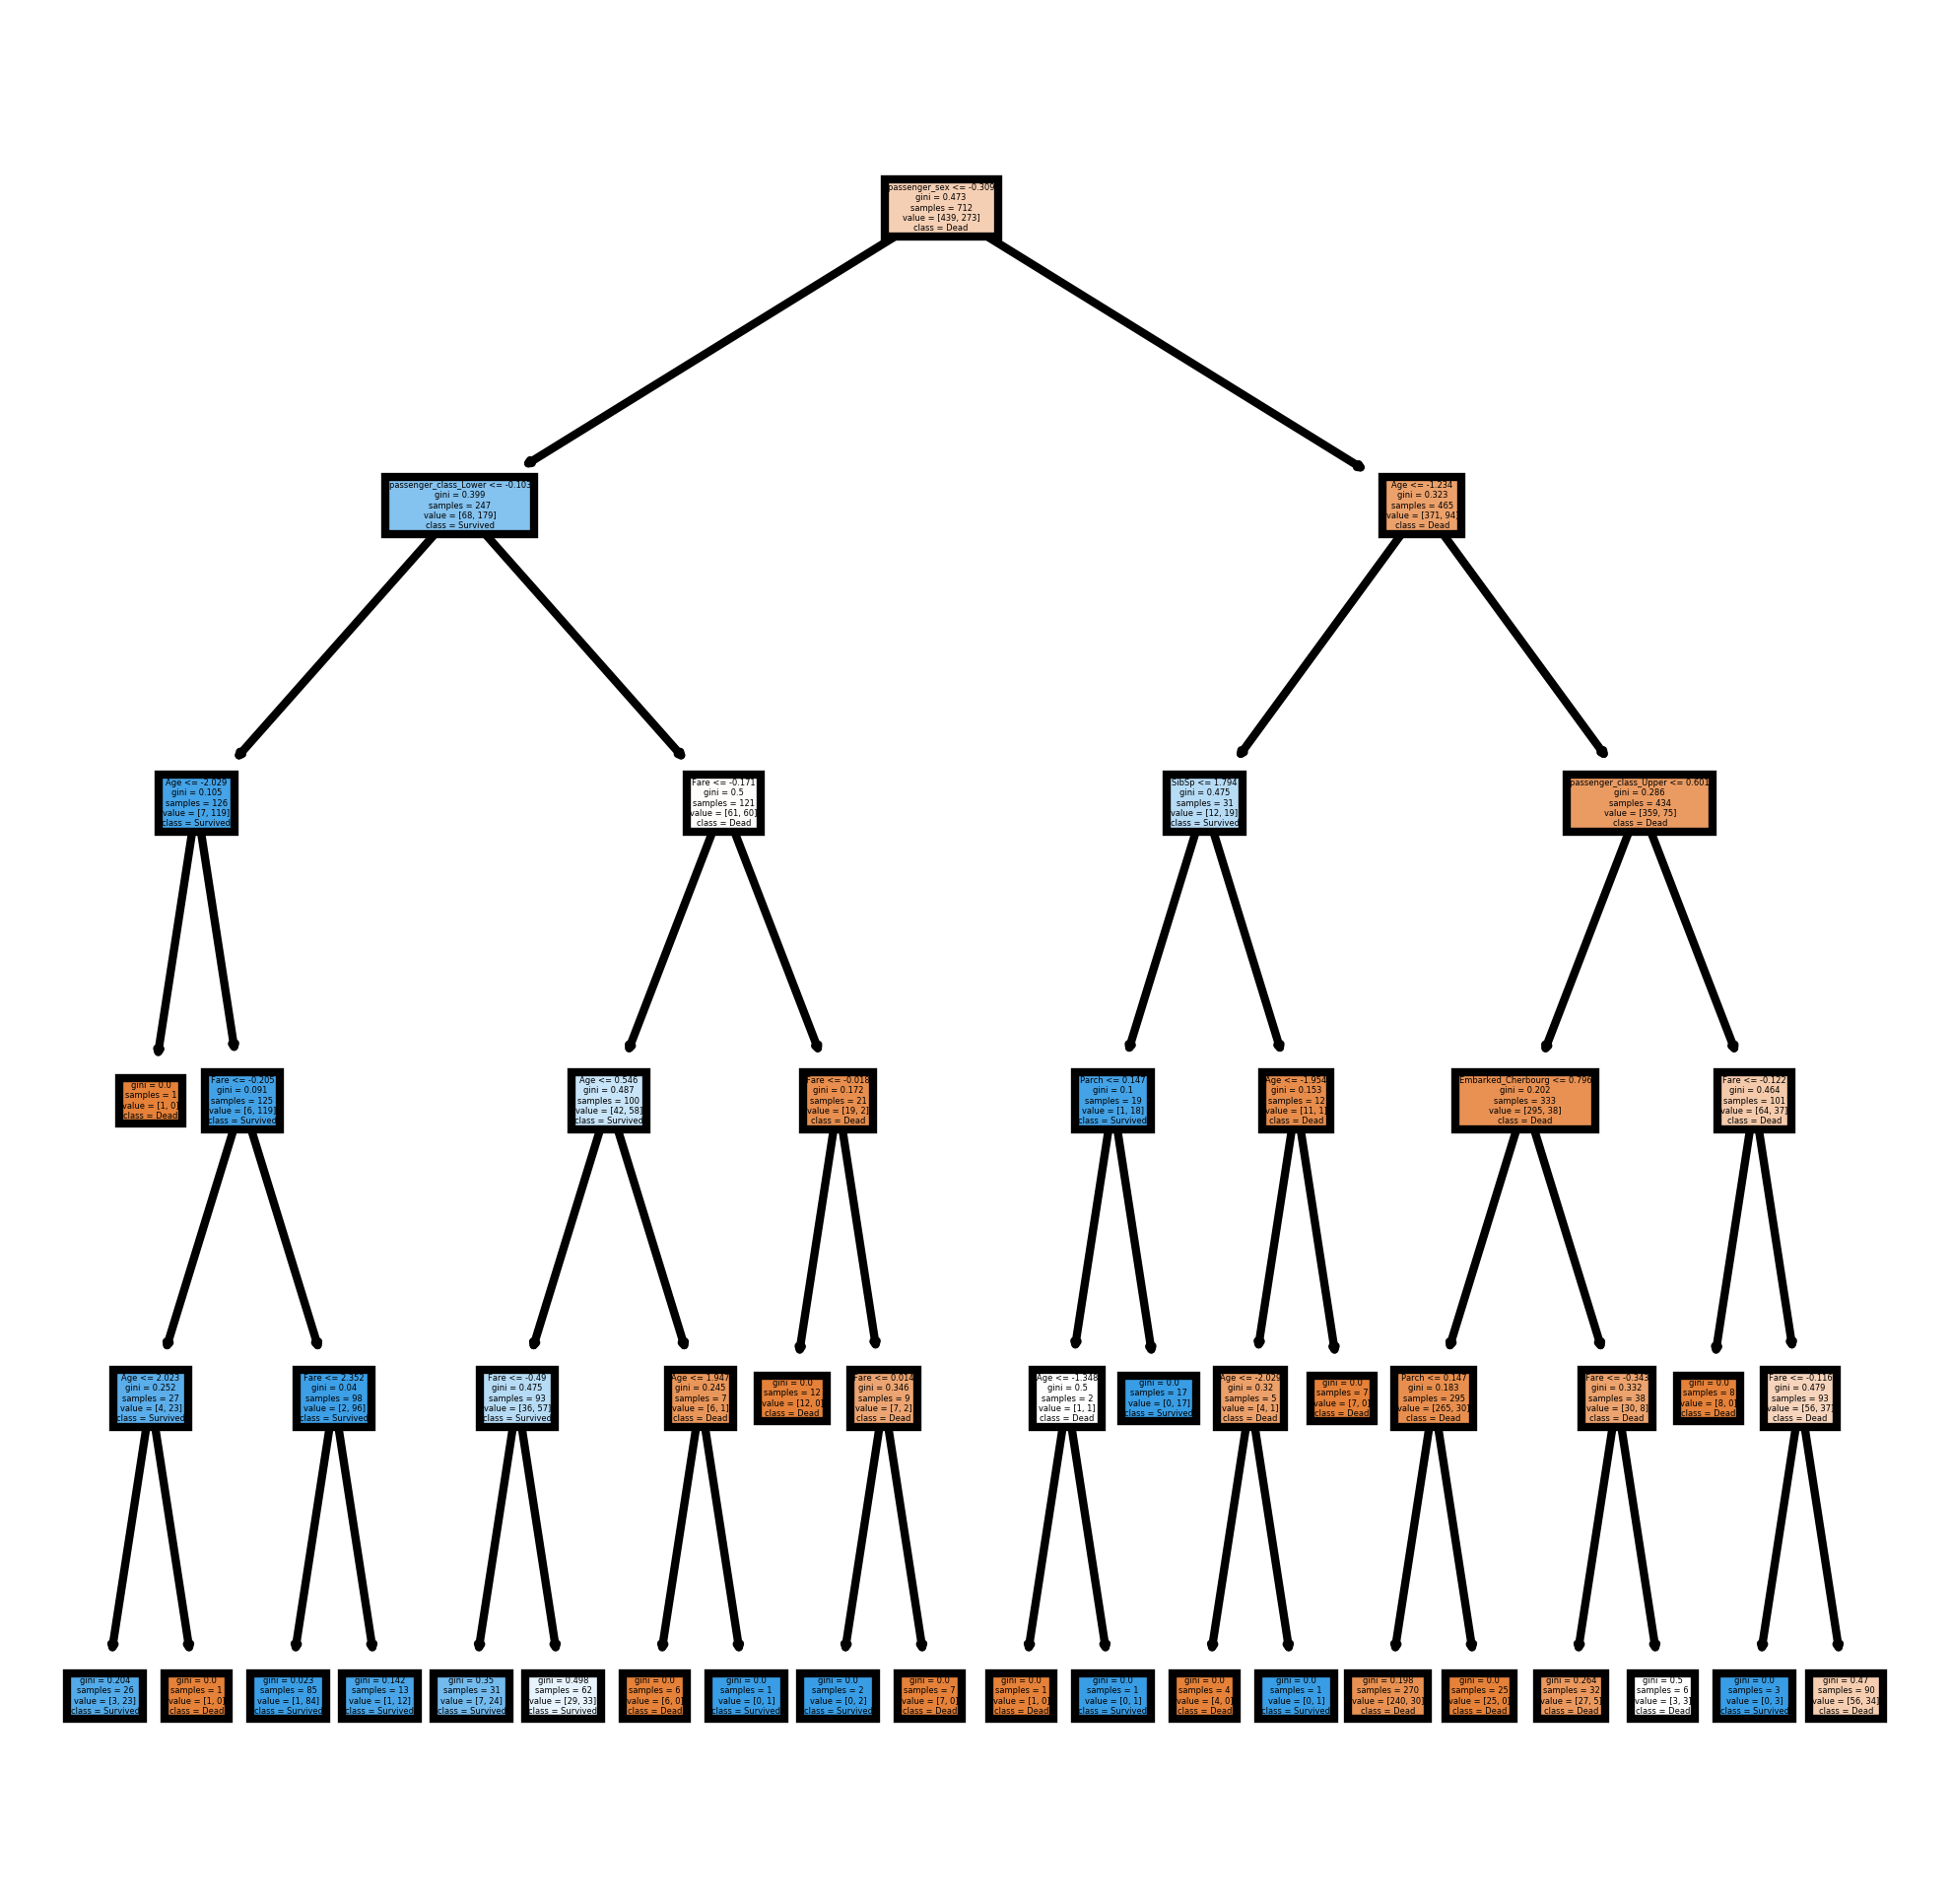

#######################################################
              Prueba Observacion 2                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


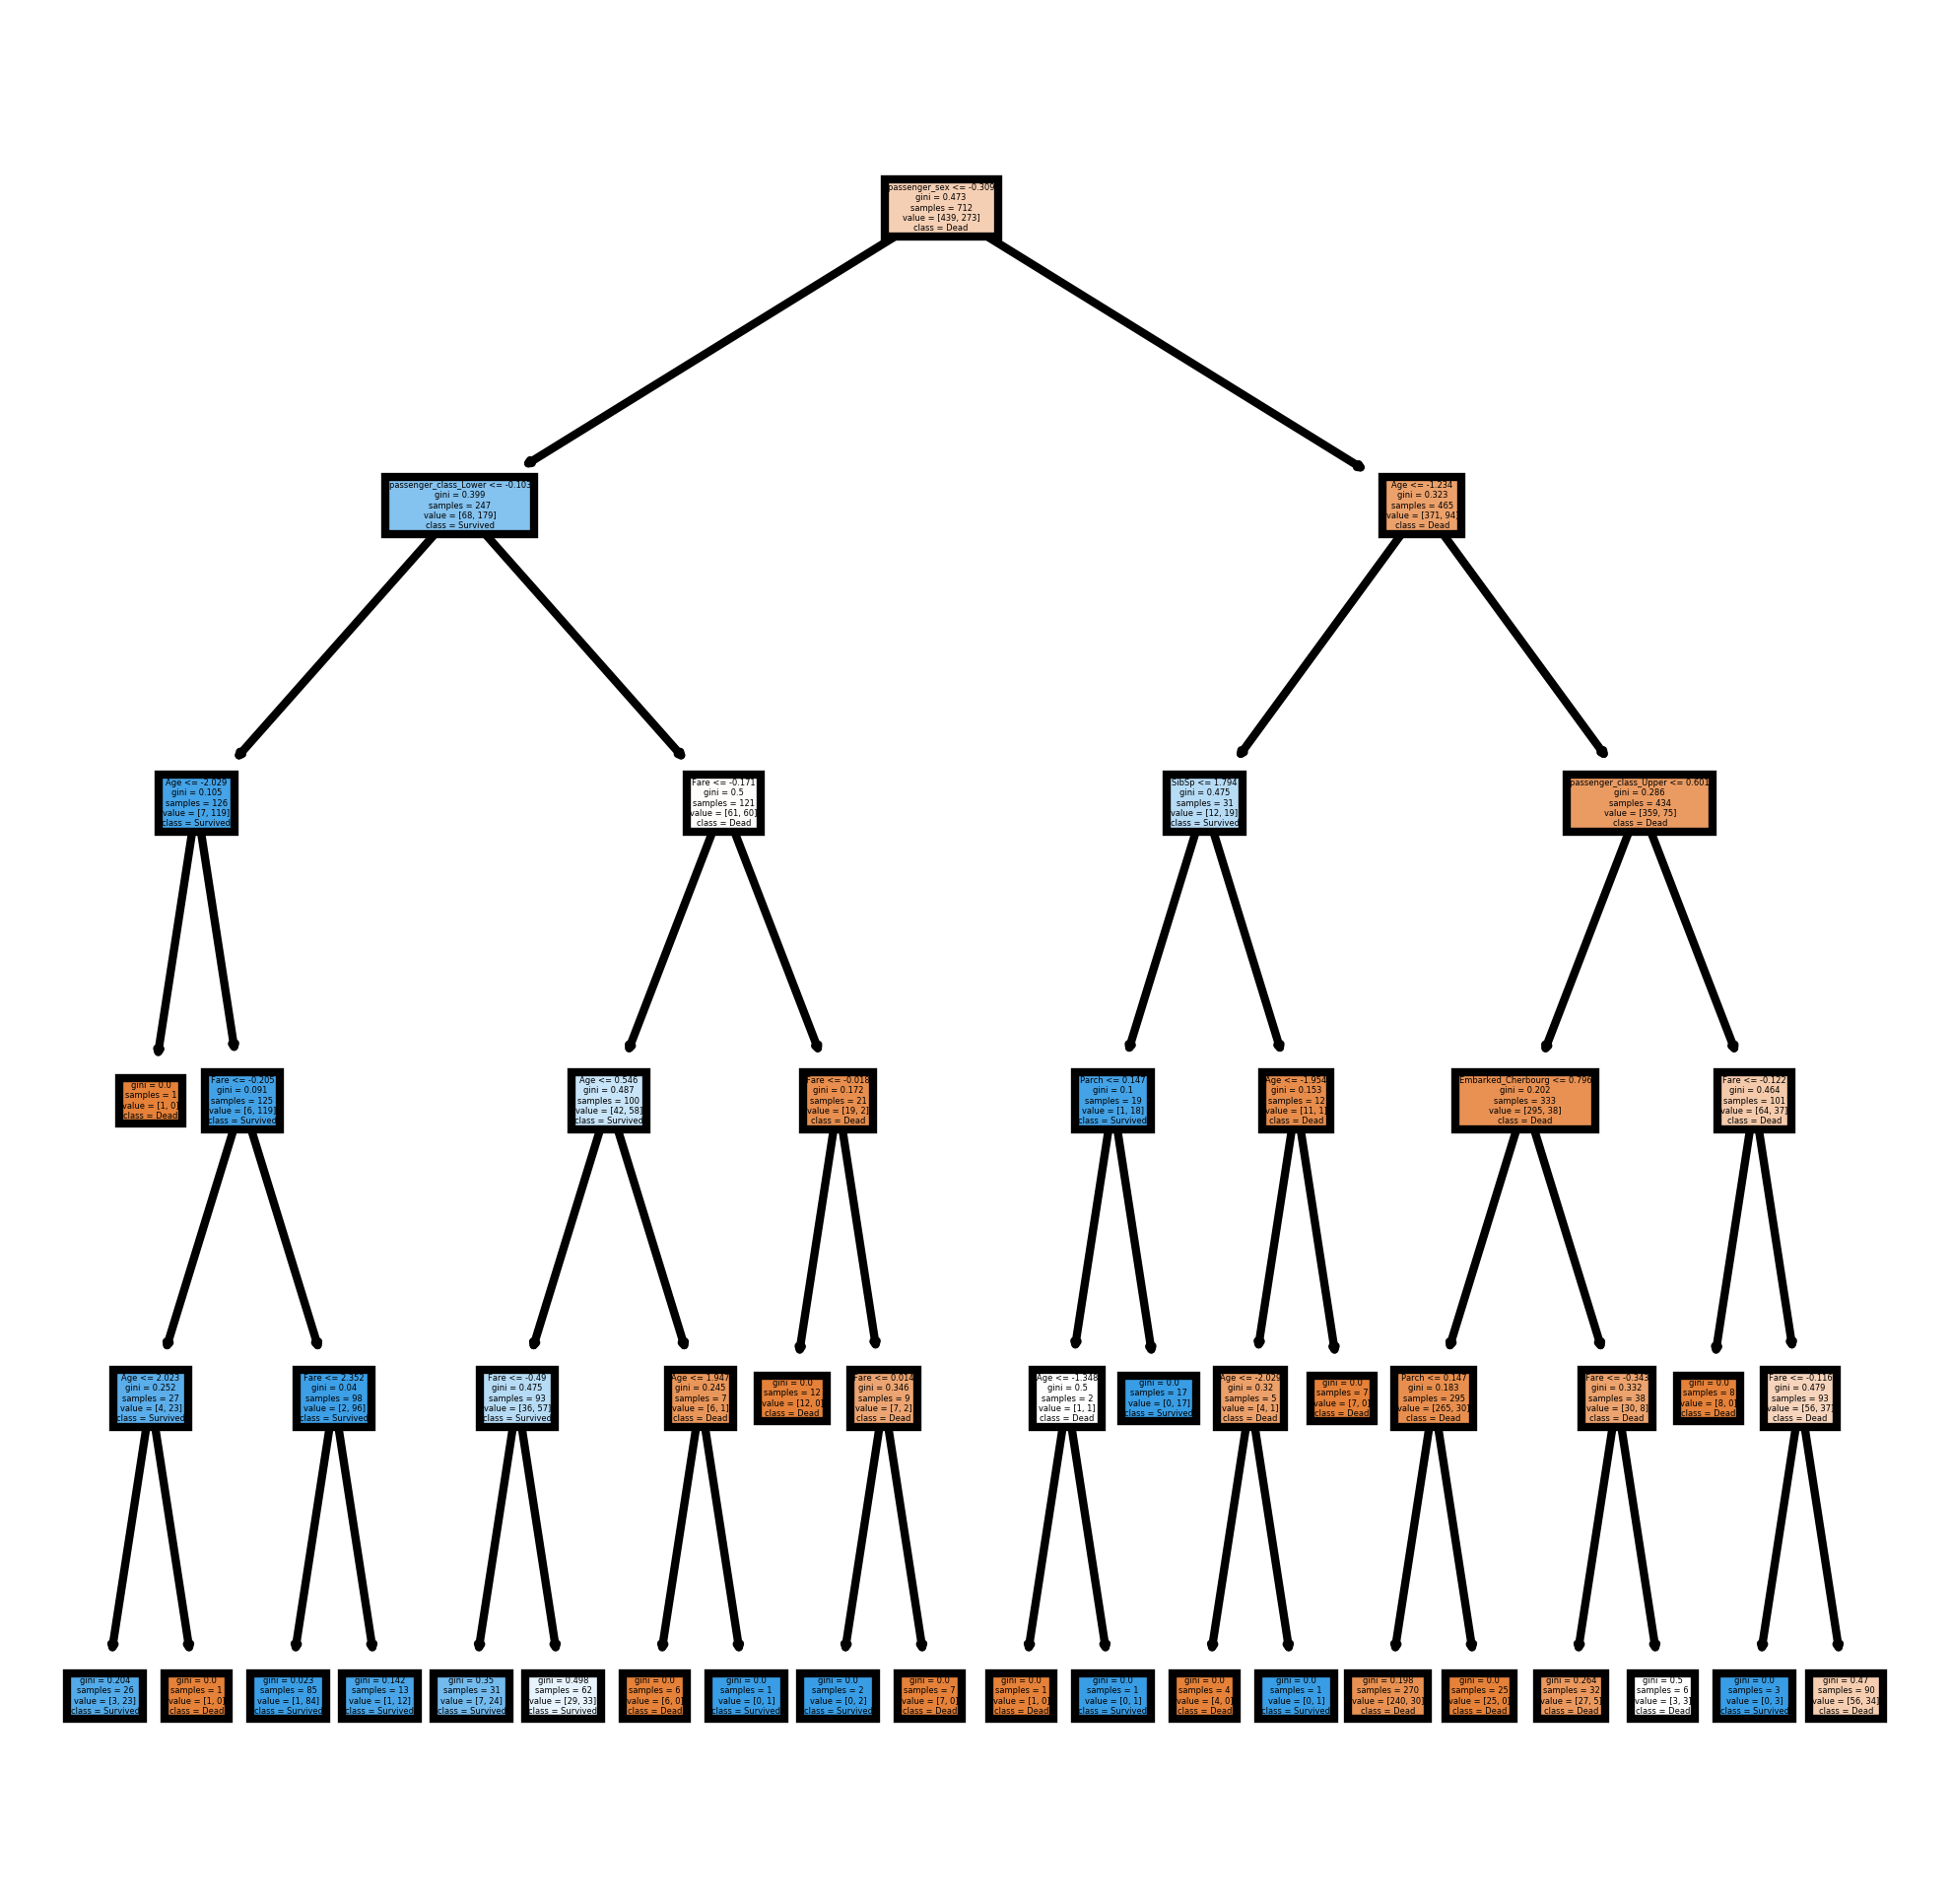

#######################################################
              Prueba Observacion 3                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


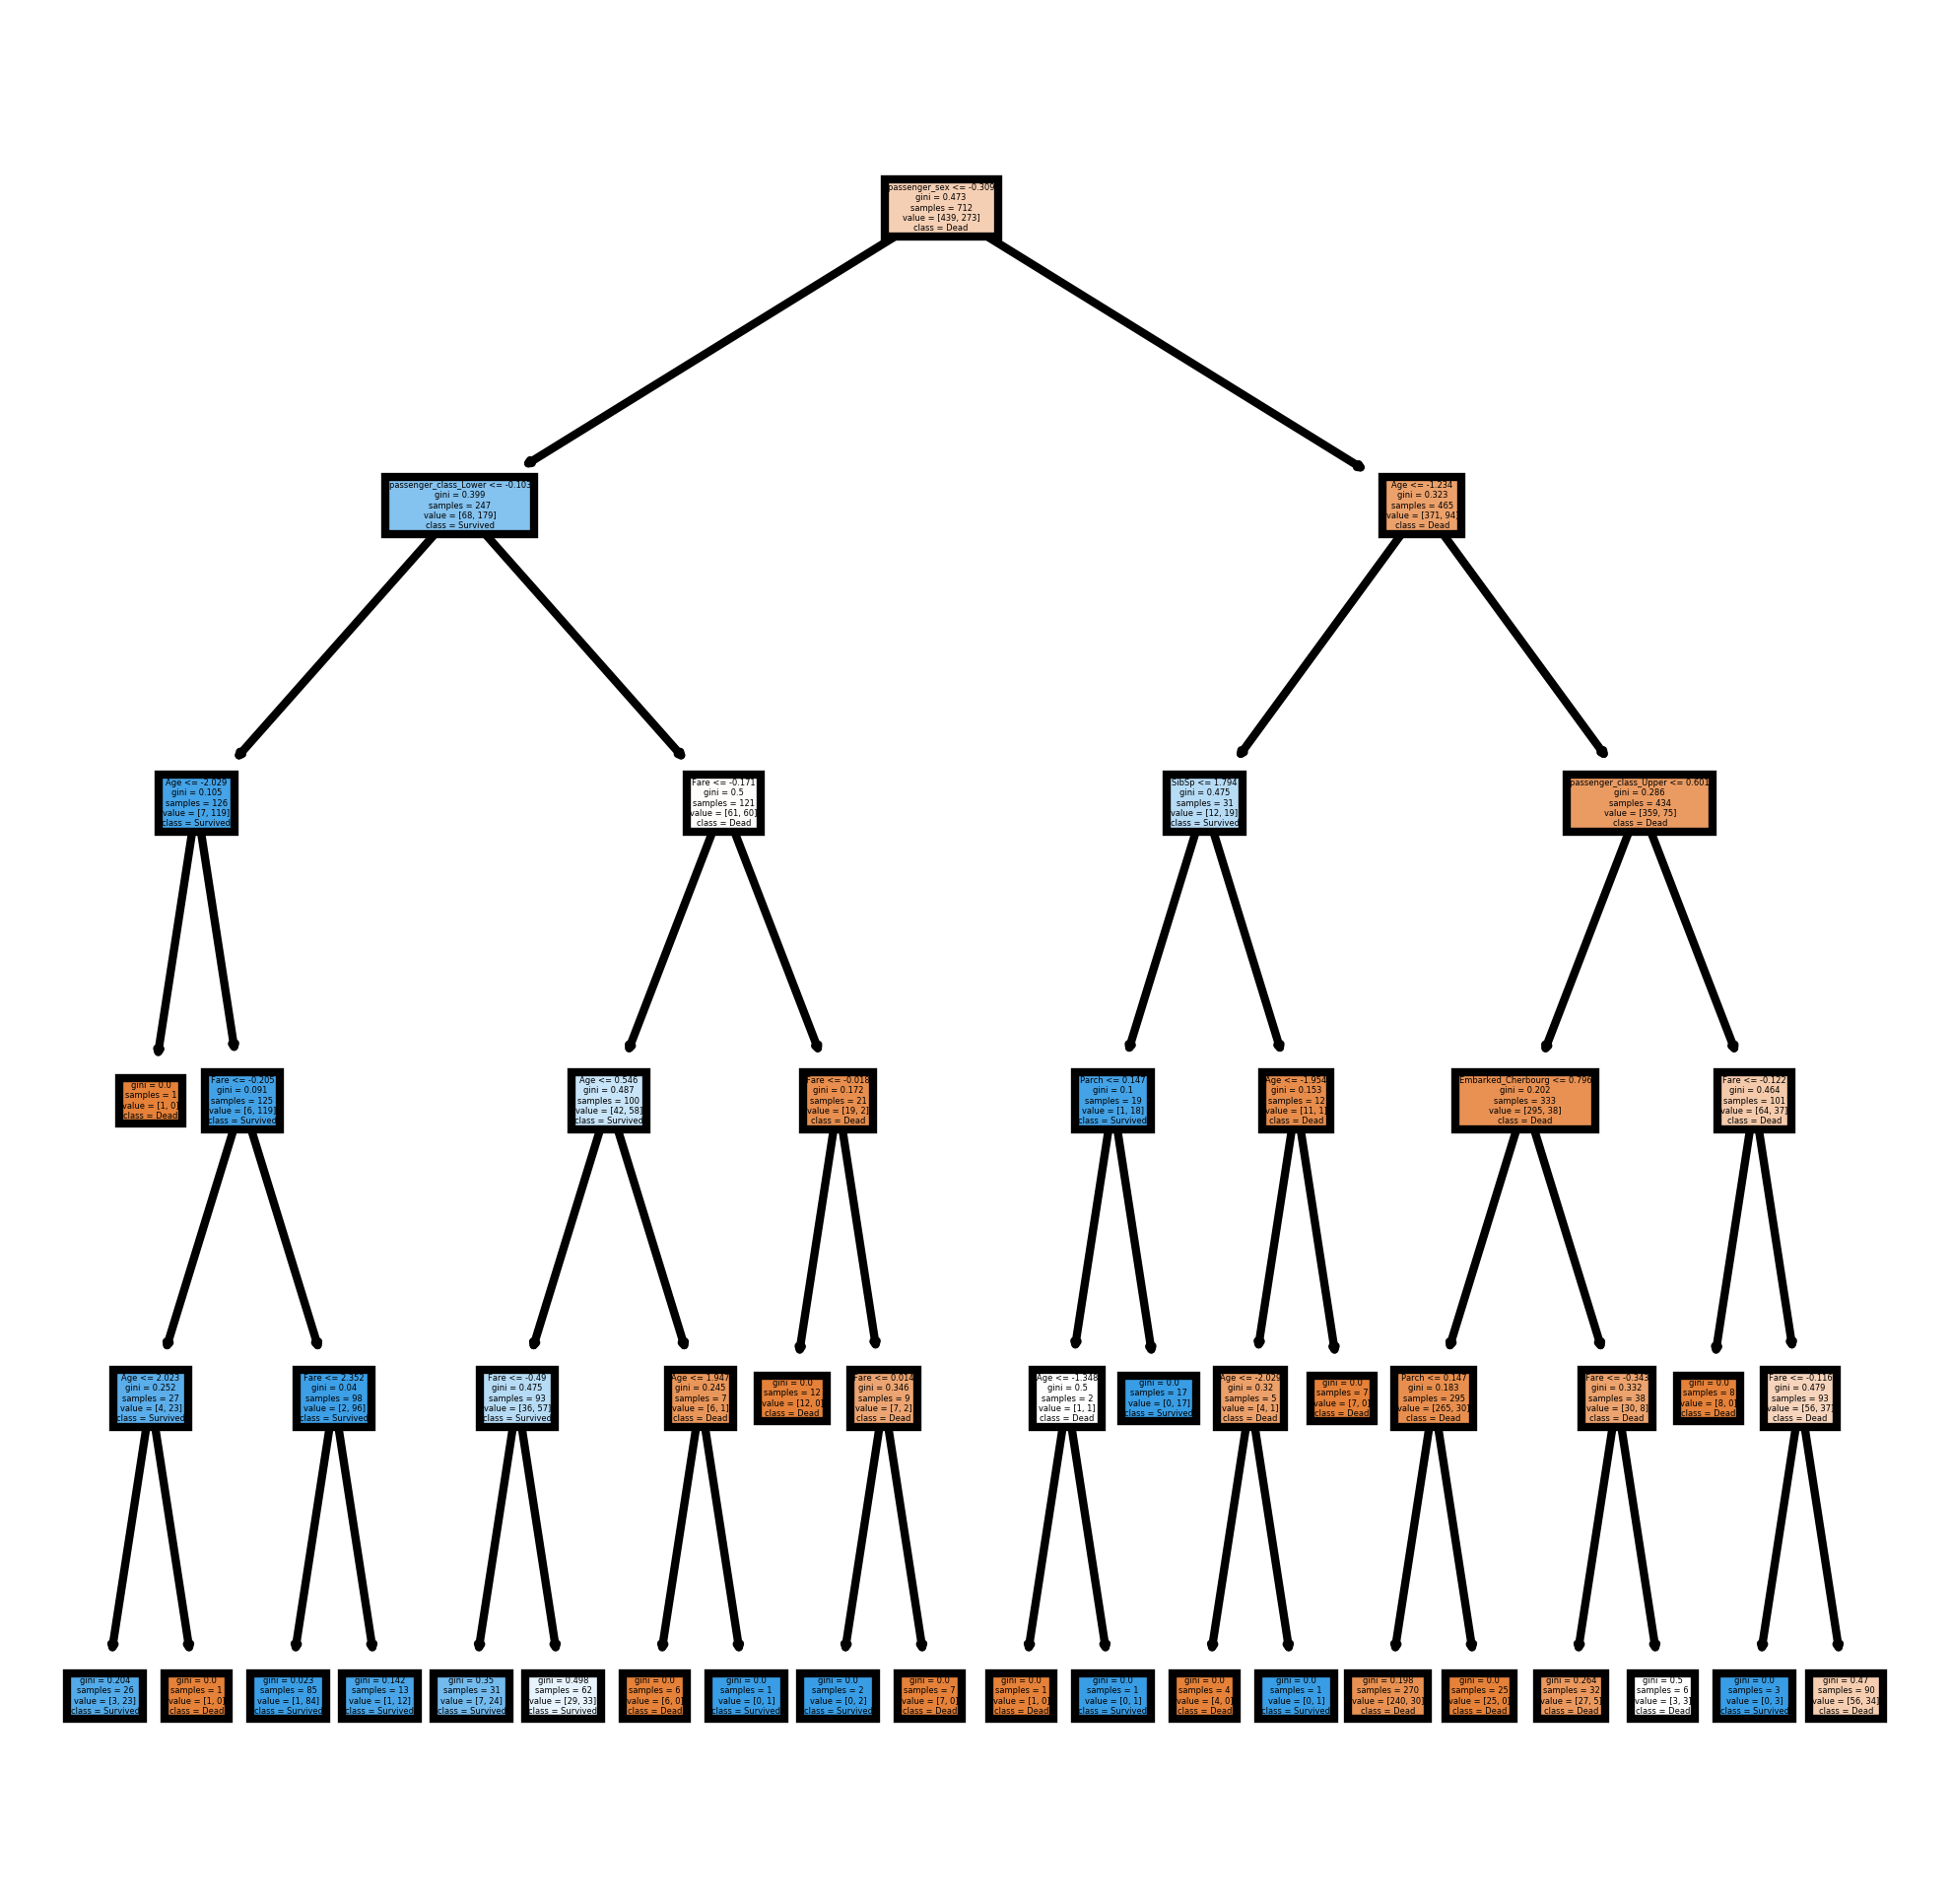

#######################################################
              Prueba Observacion 4                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


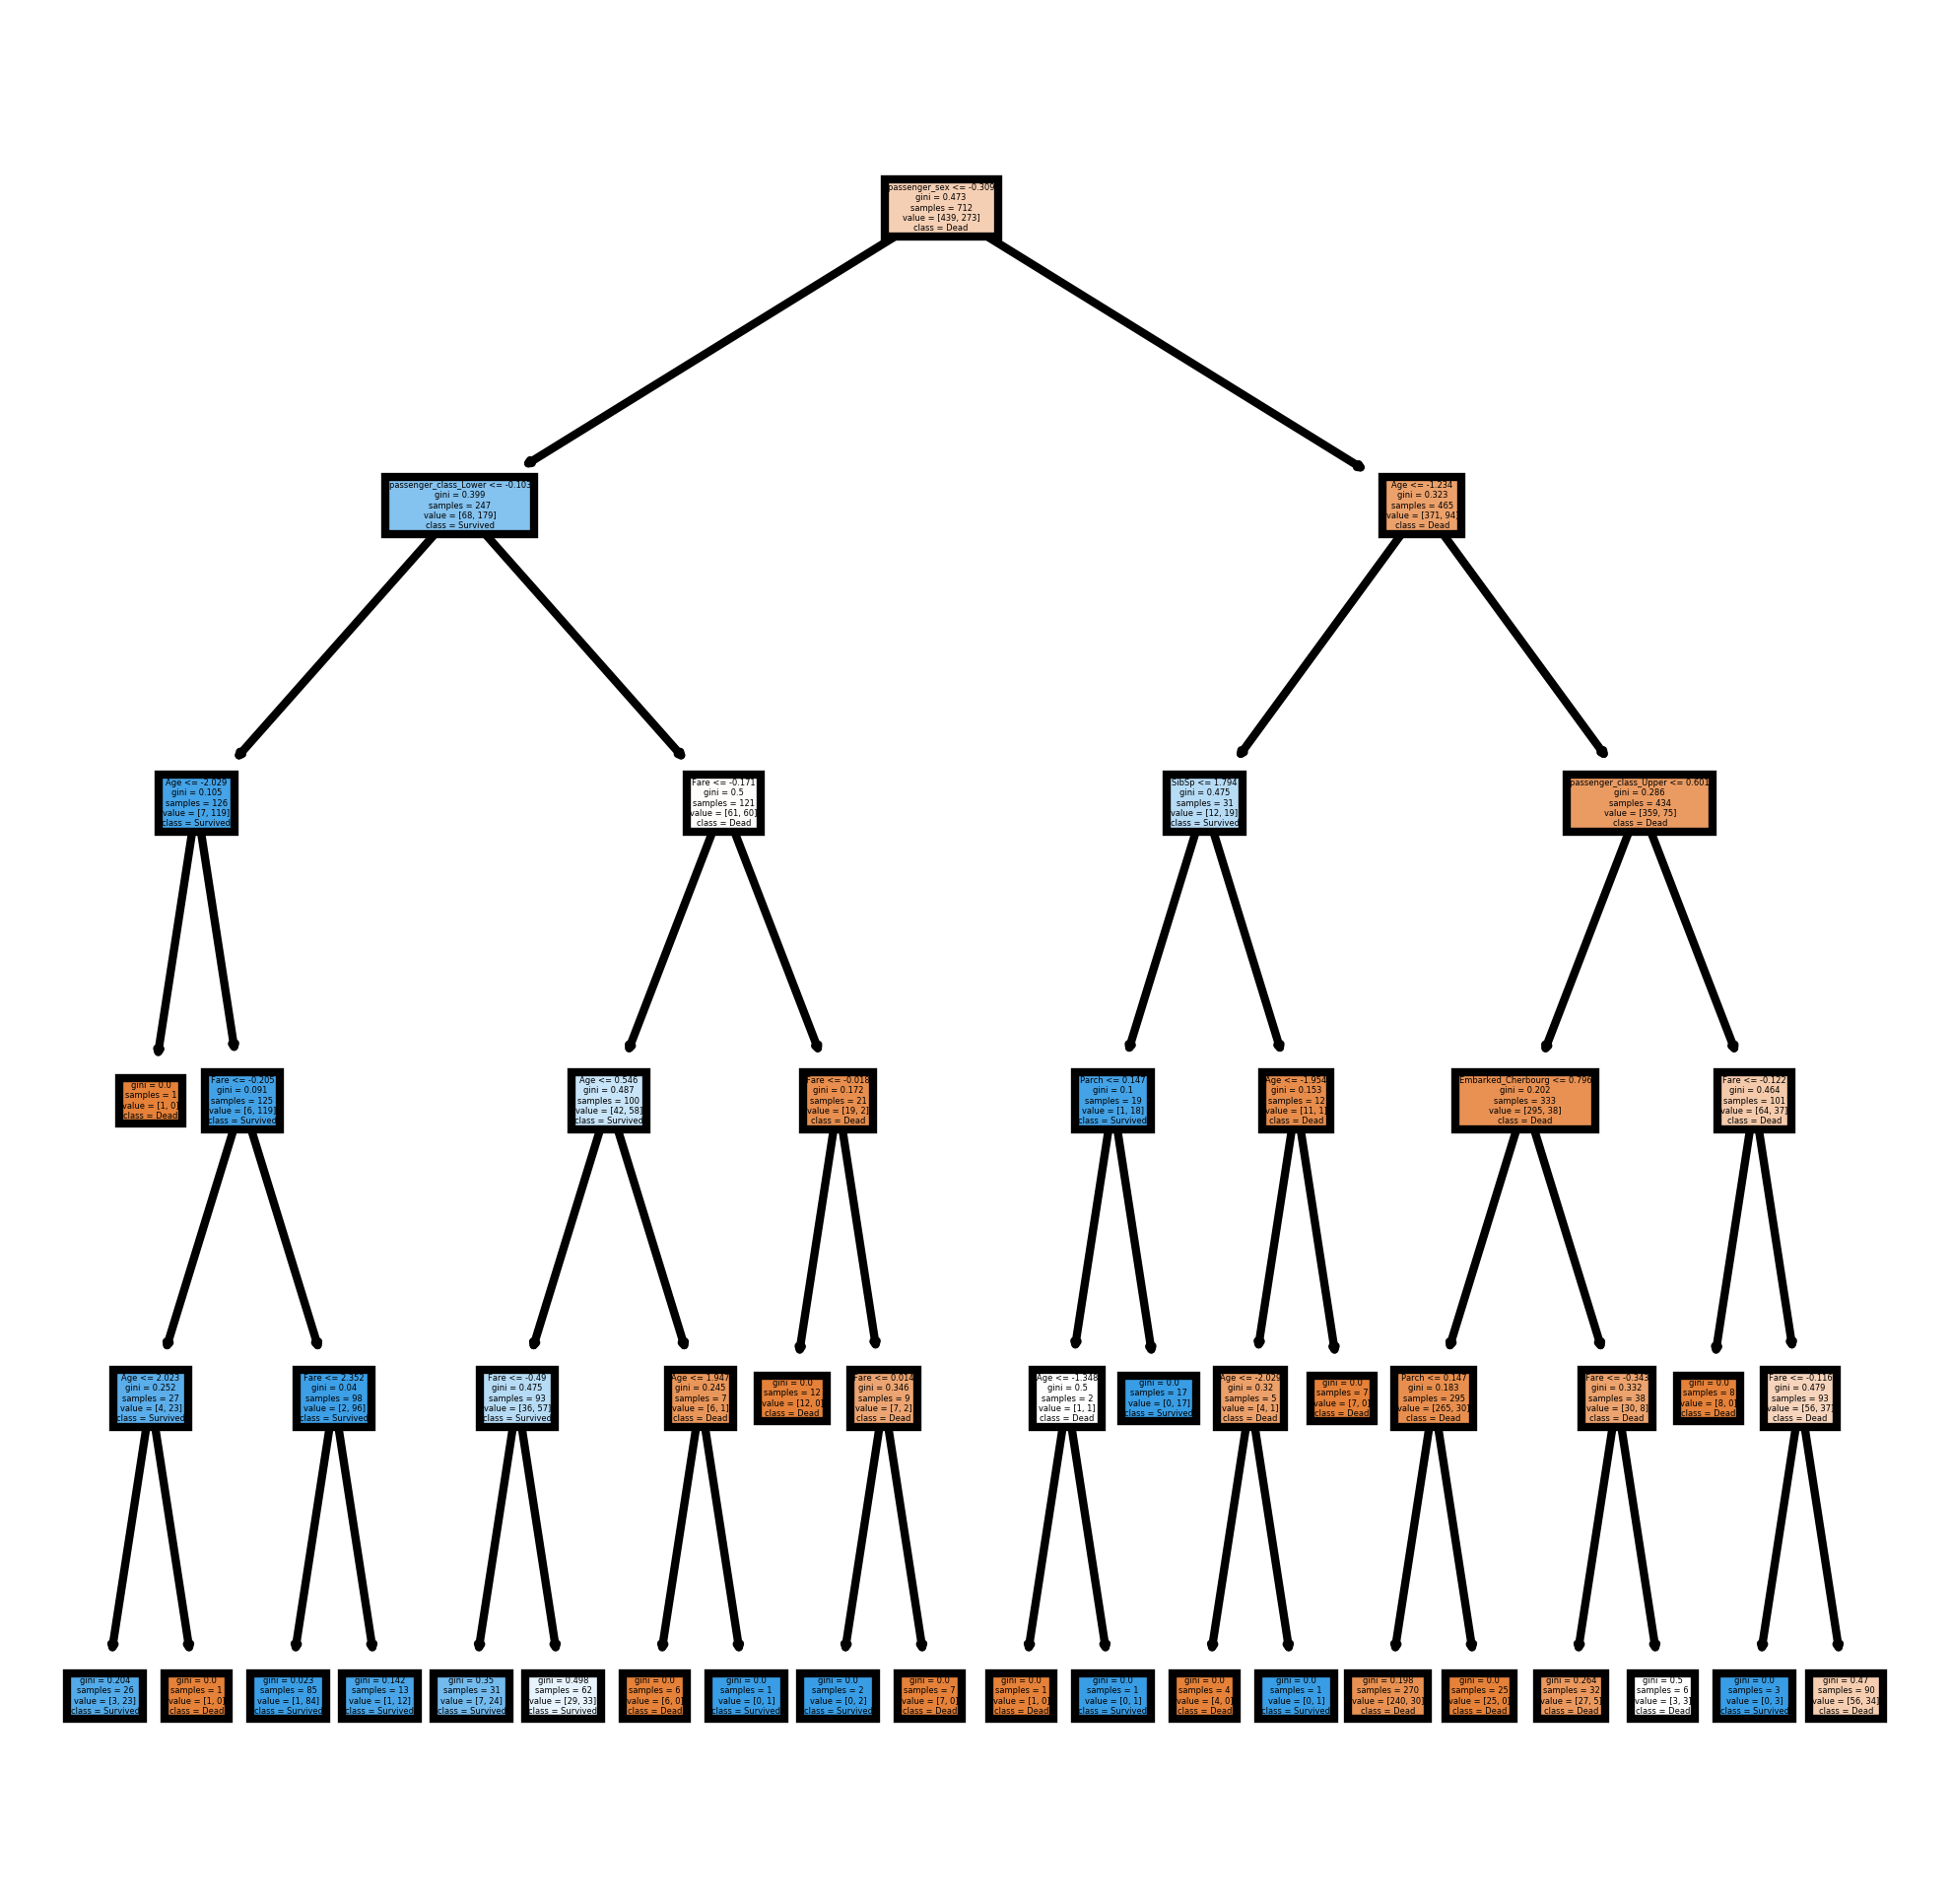

#######################################################
              Prueba Observacion 5                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


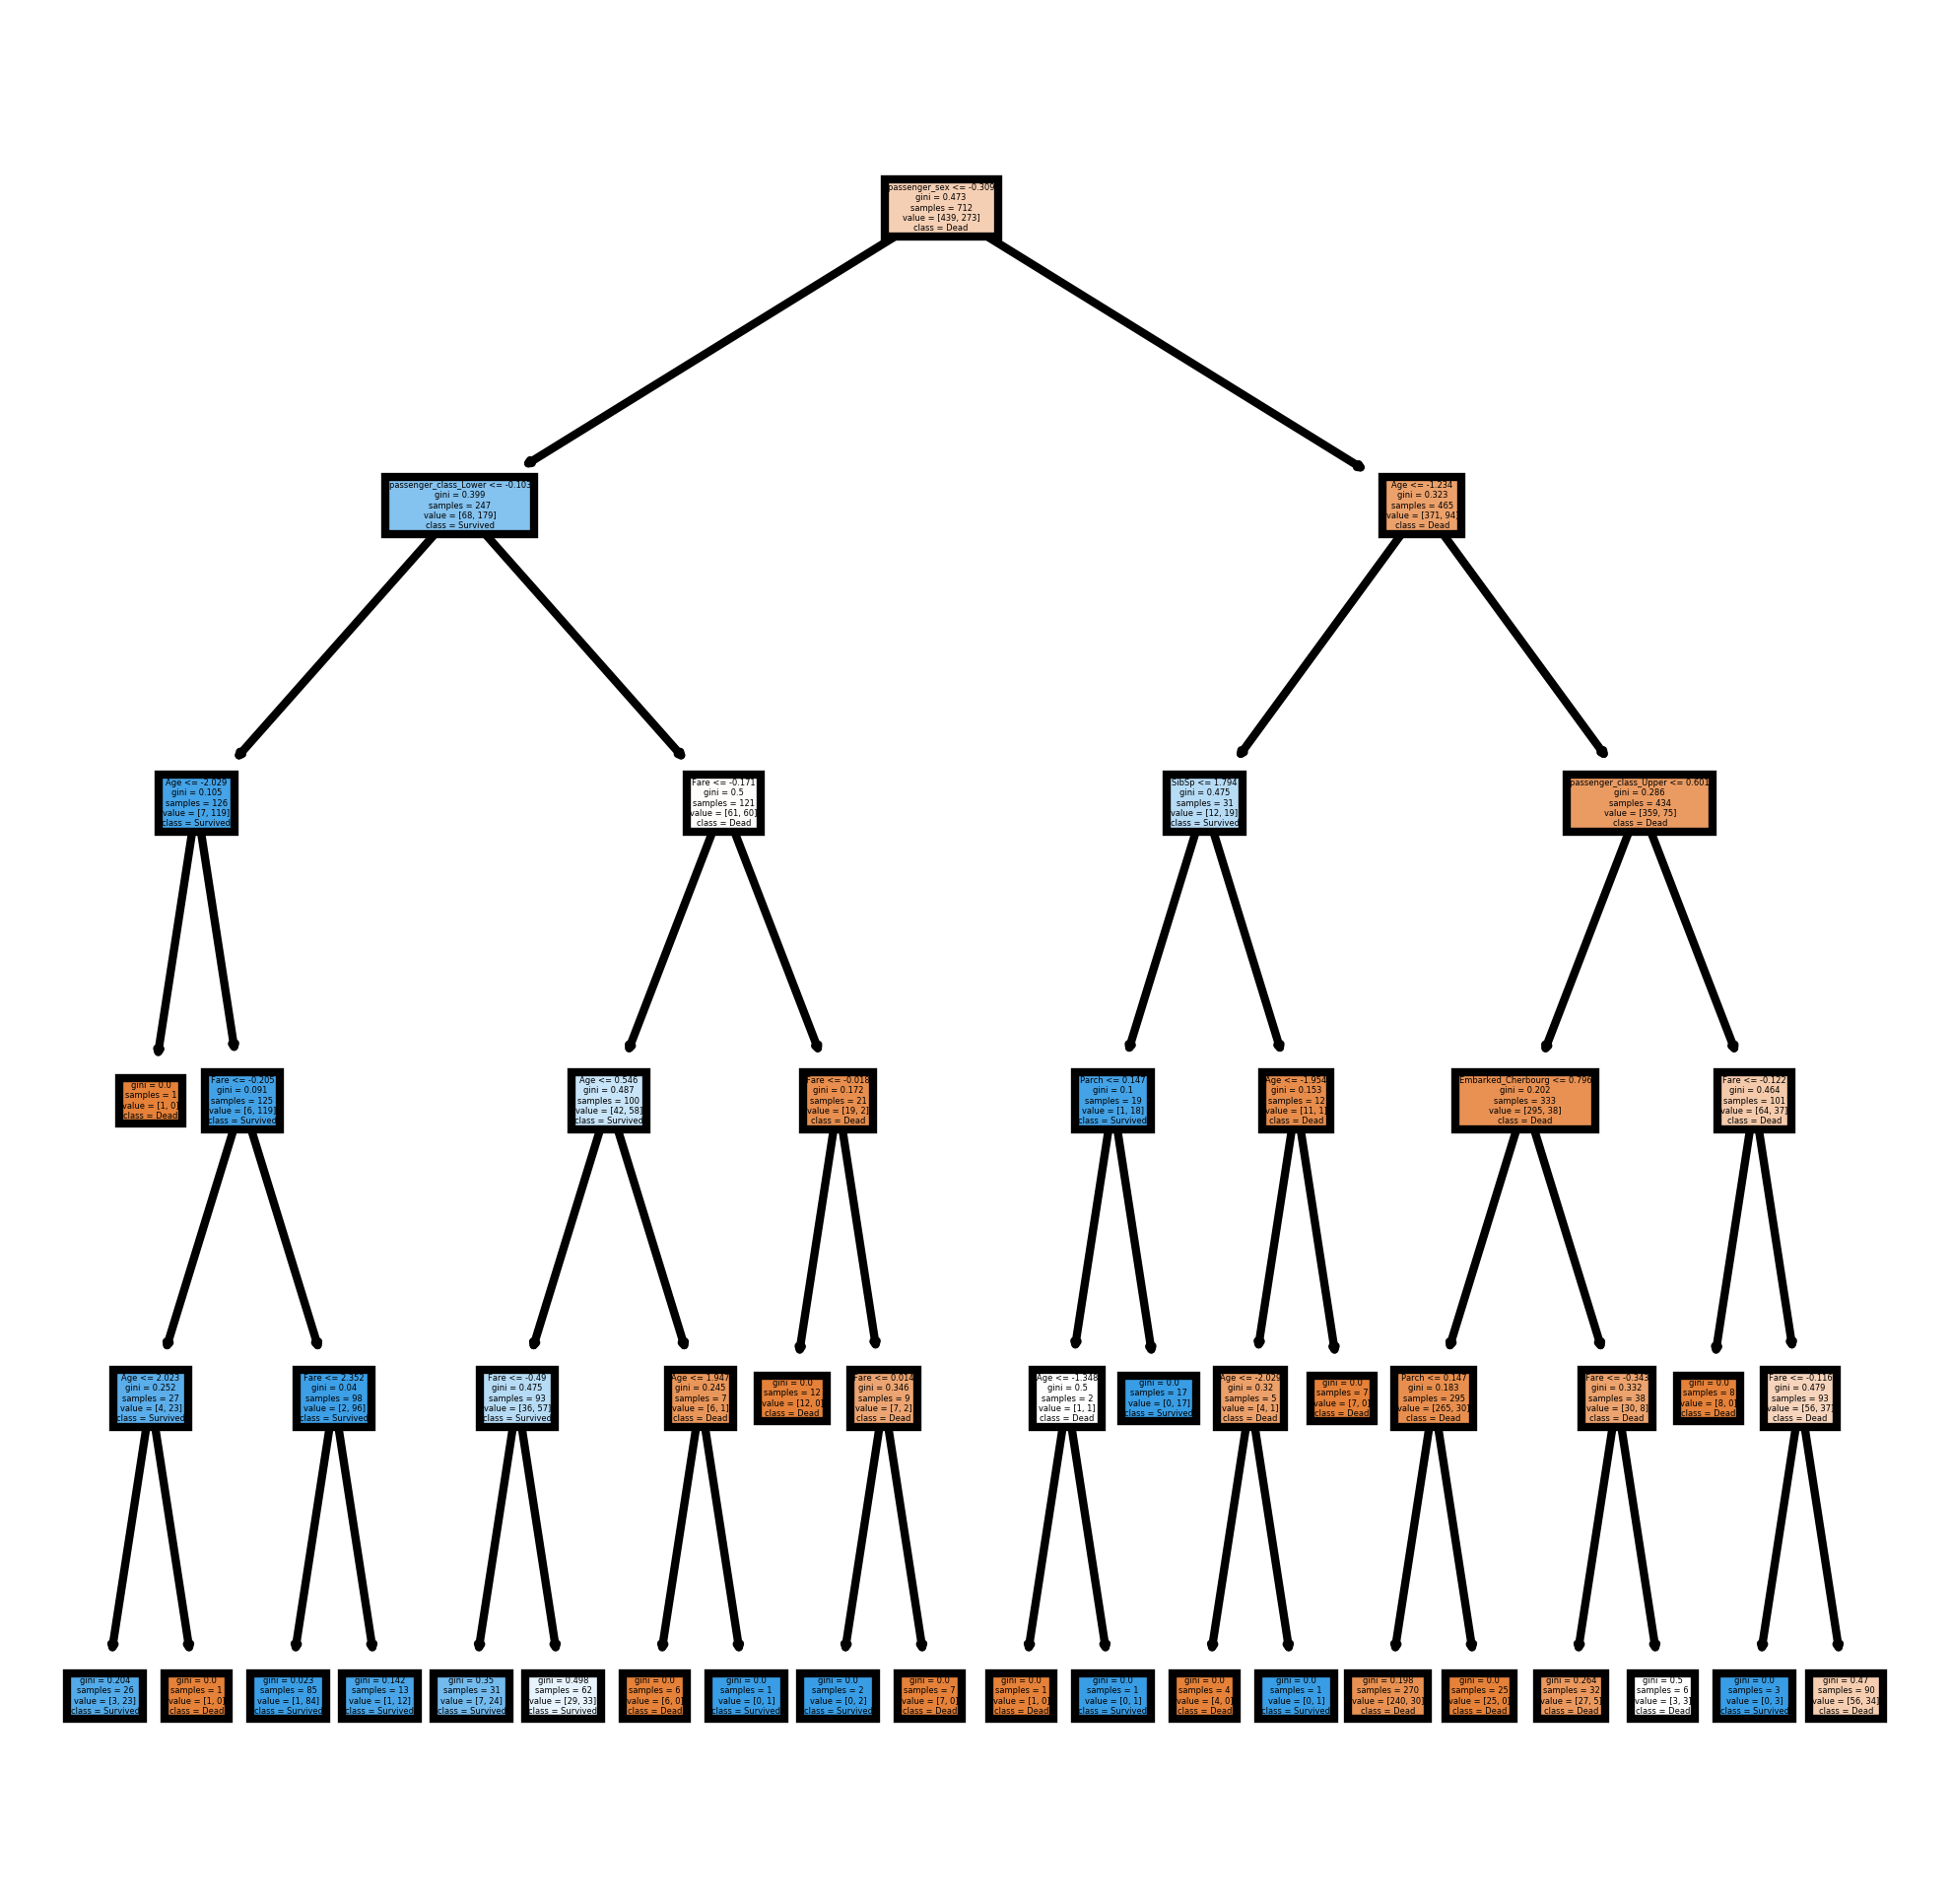

#######################################################
              Prueba Observacion 6                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


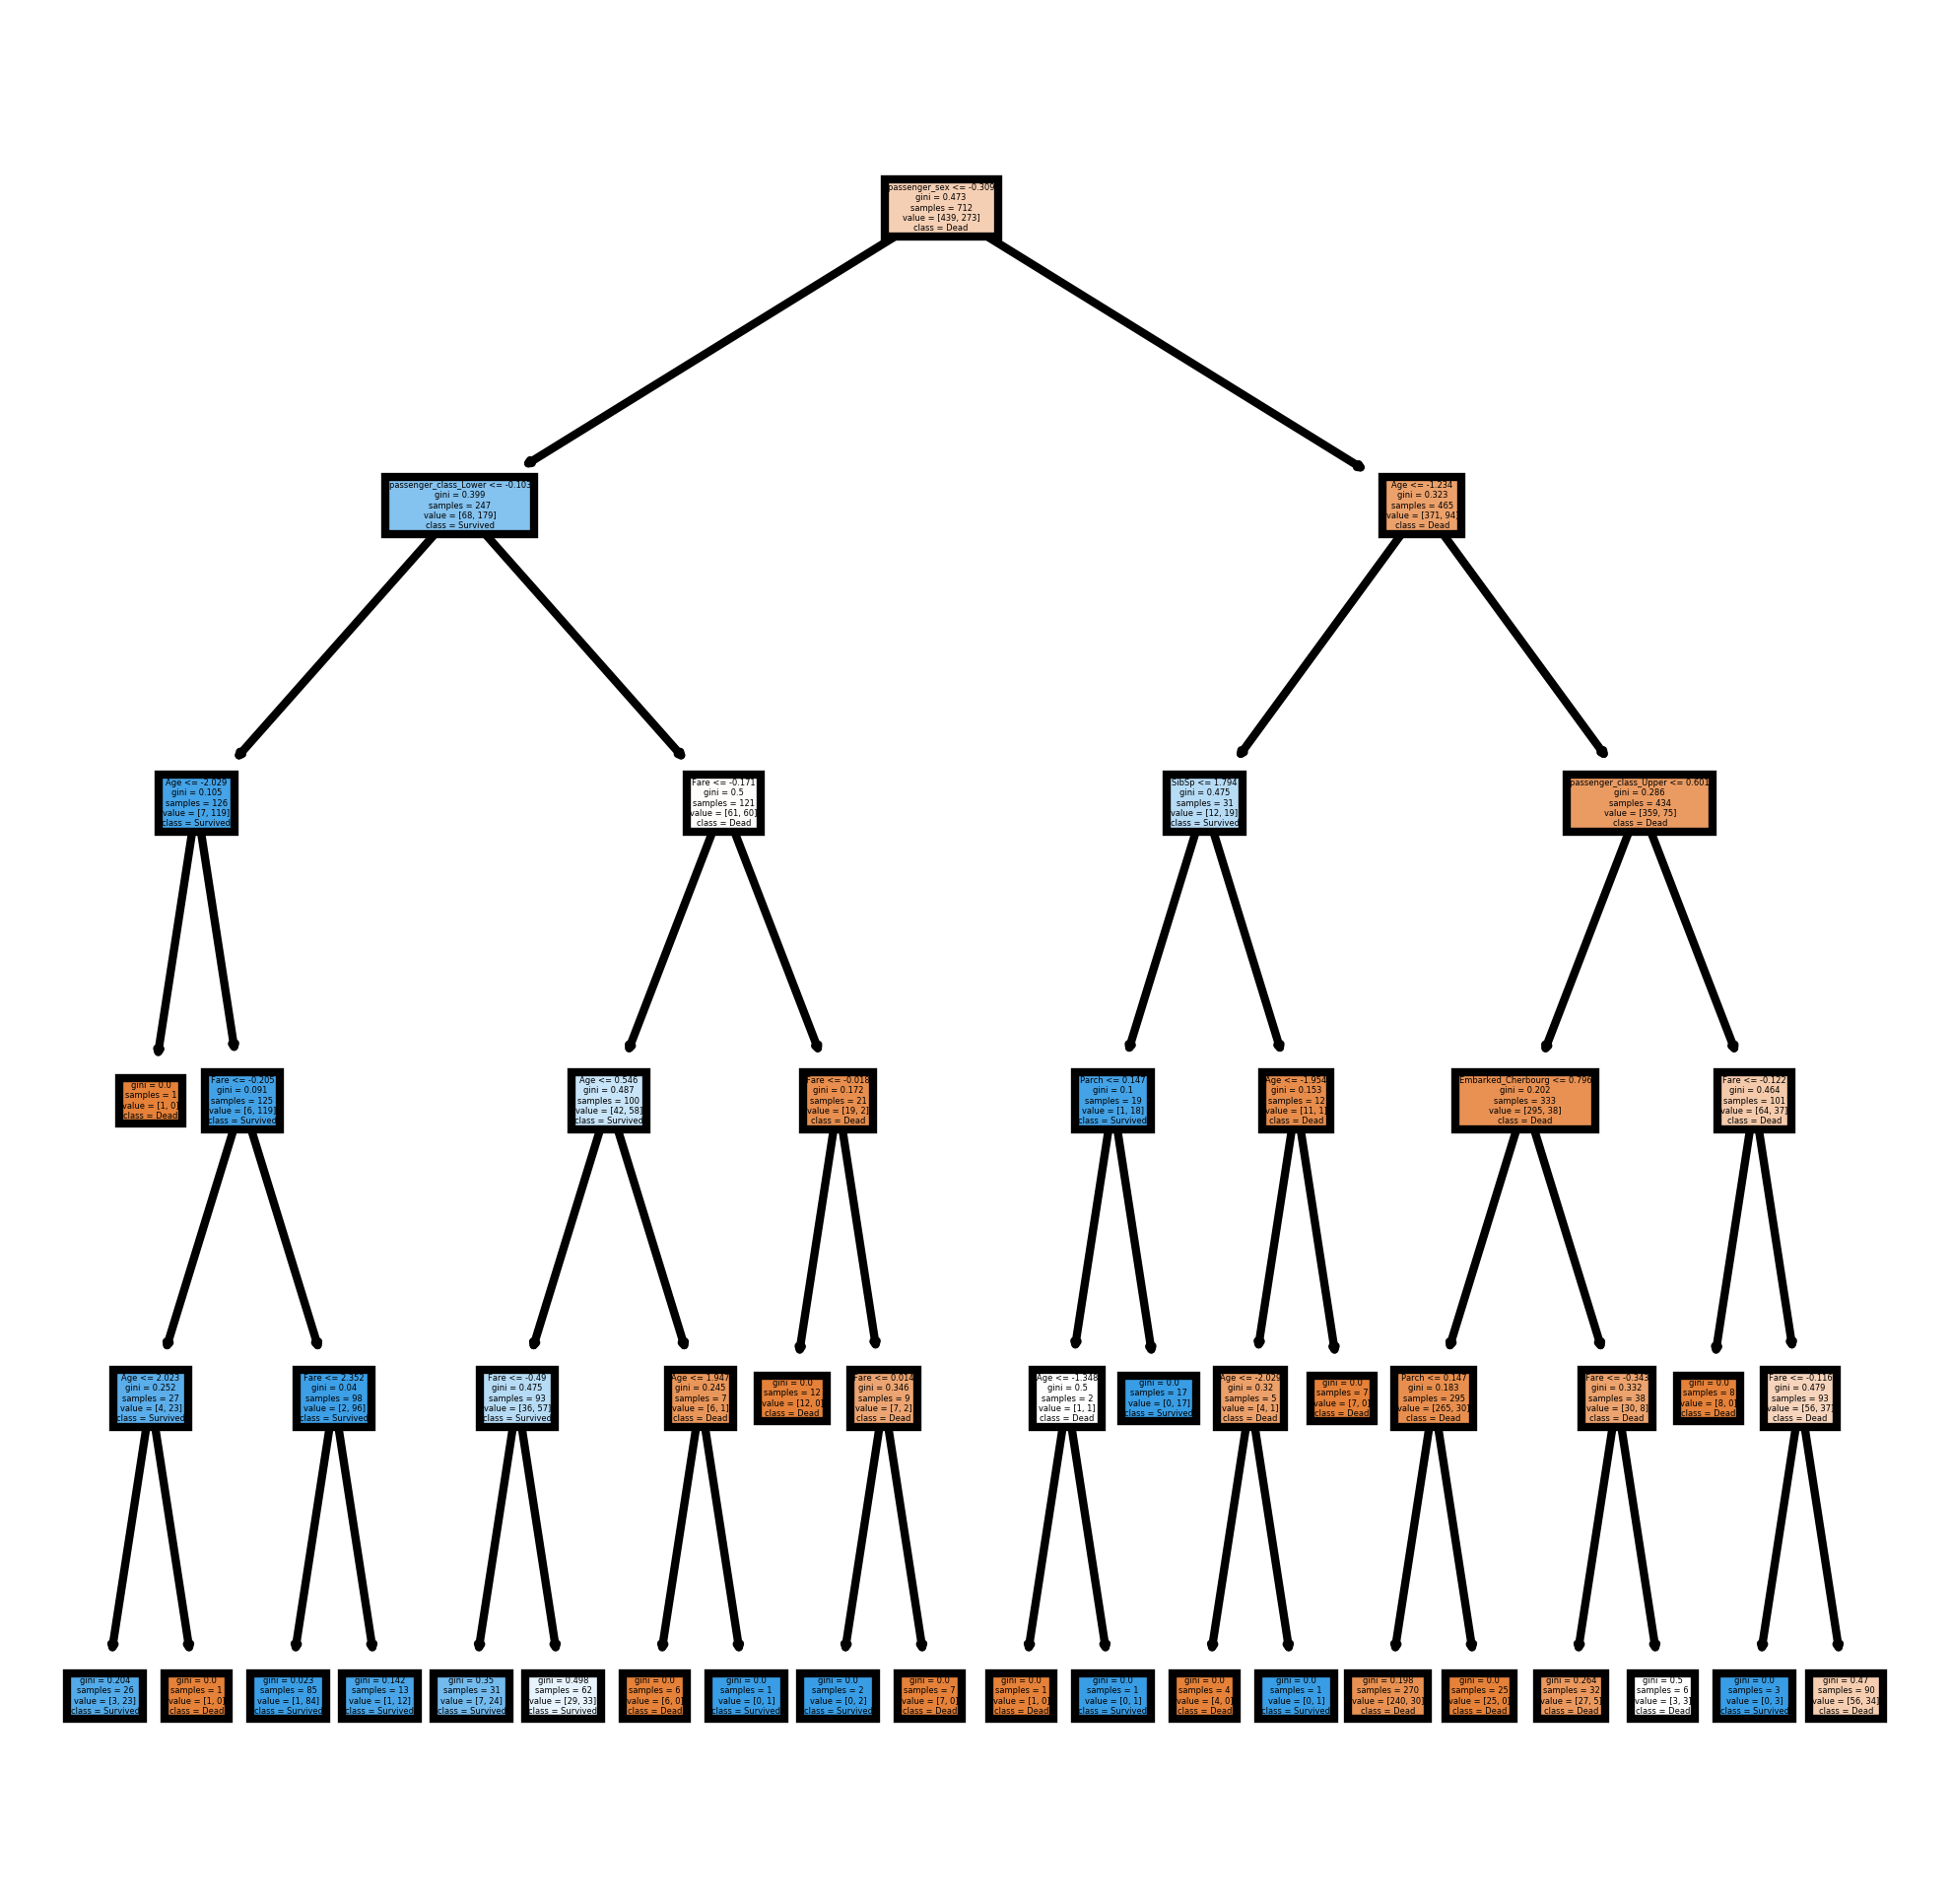

#######################################################
              Prueba Observacion 7                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


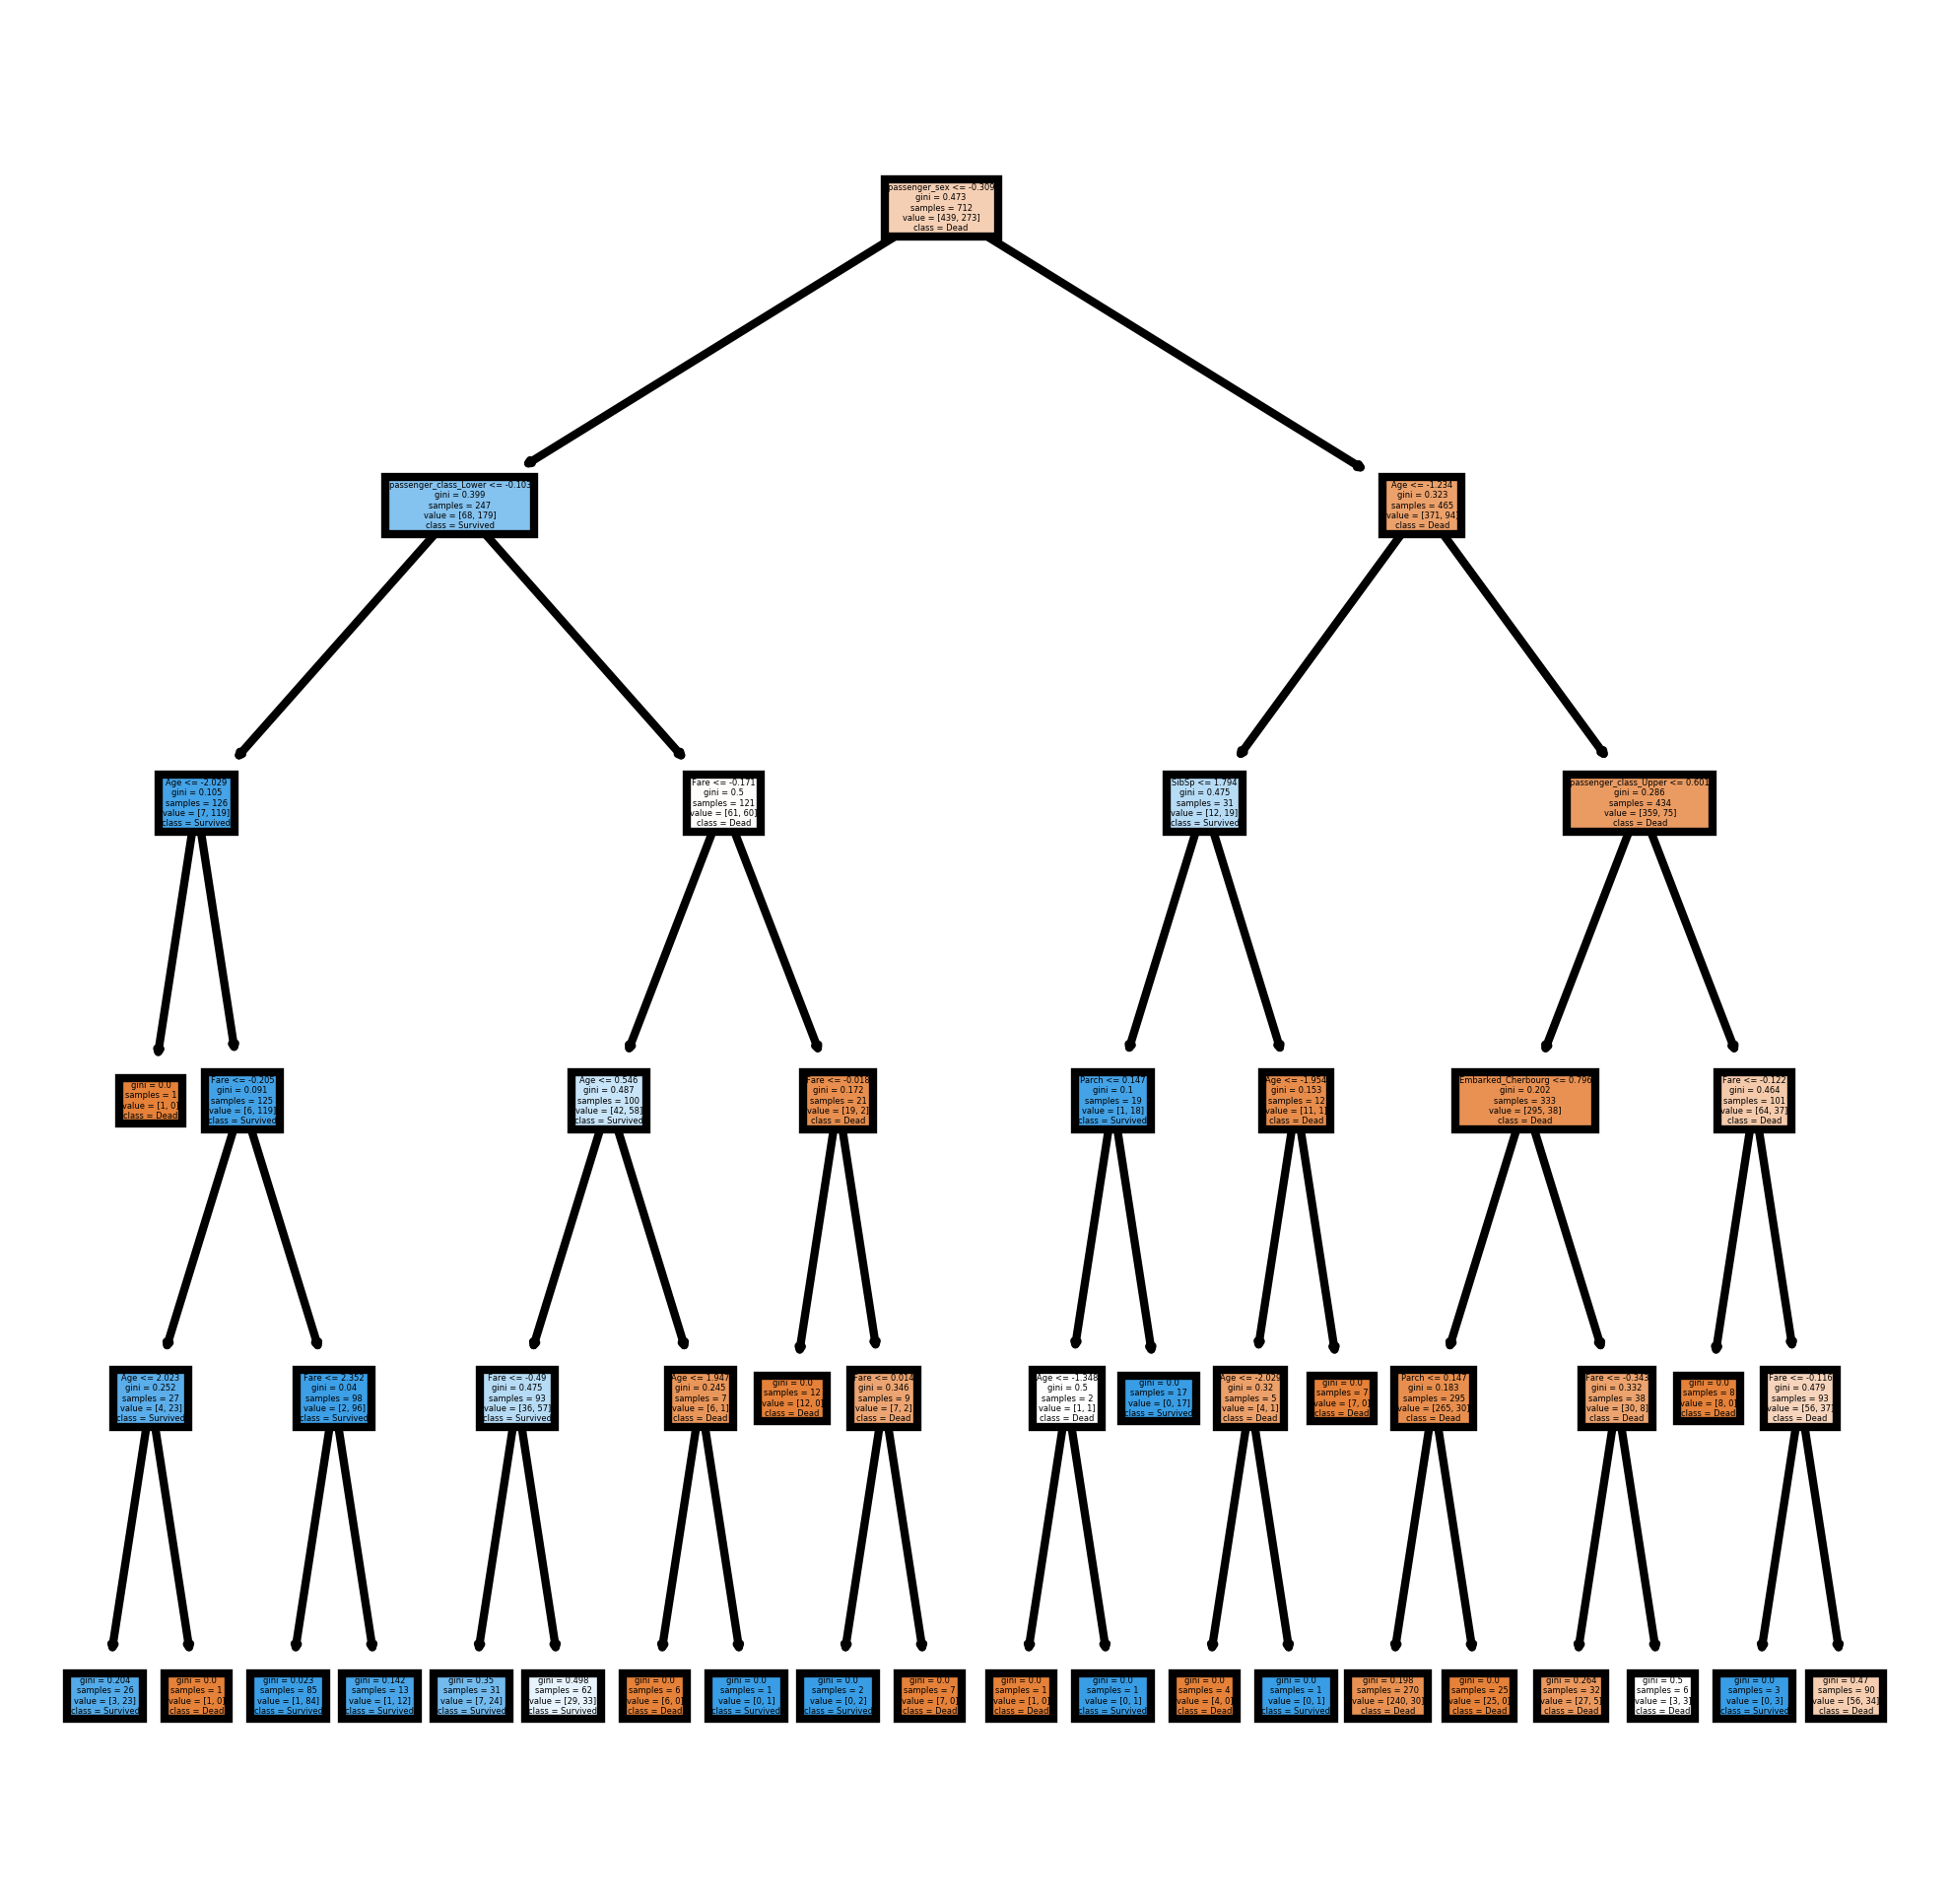

#######################################################
              Prueba Observacion 8                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


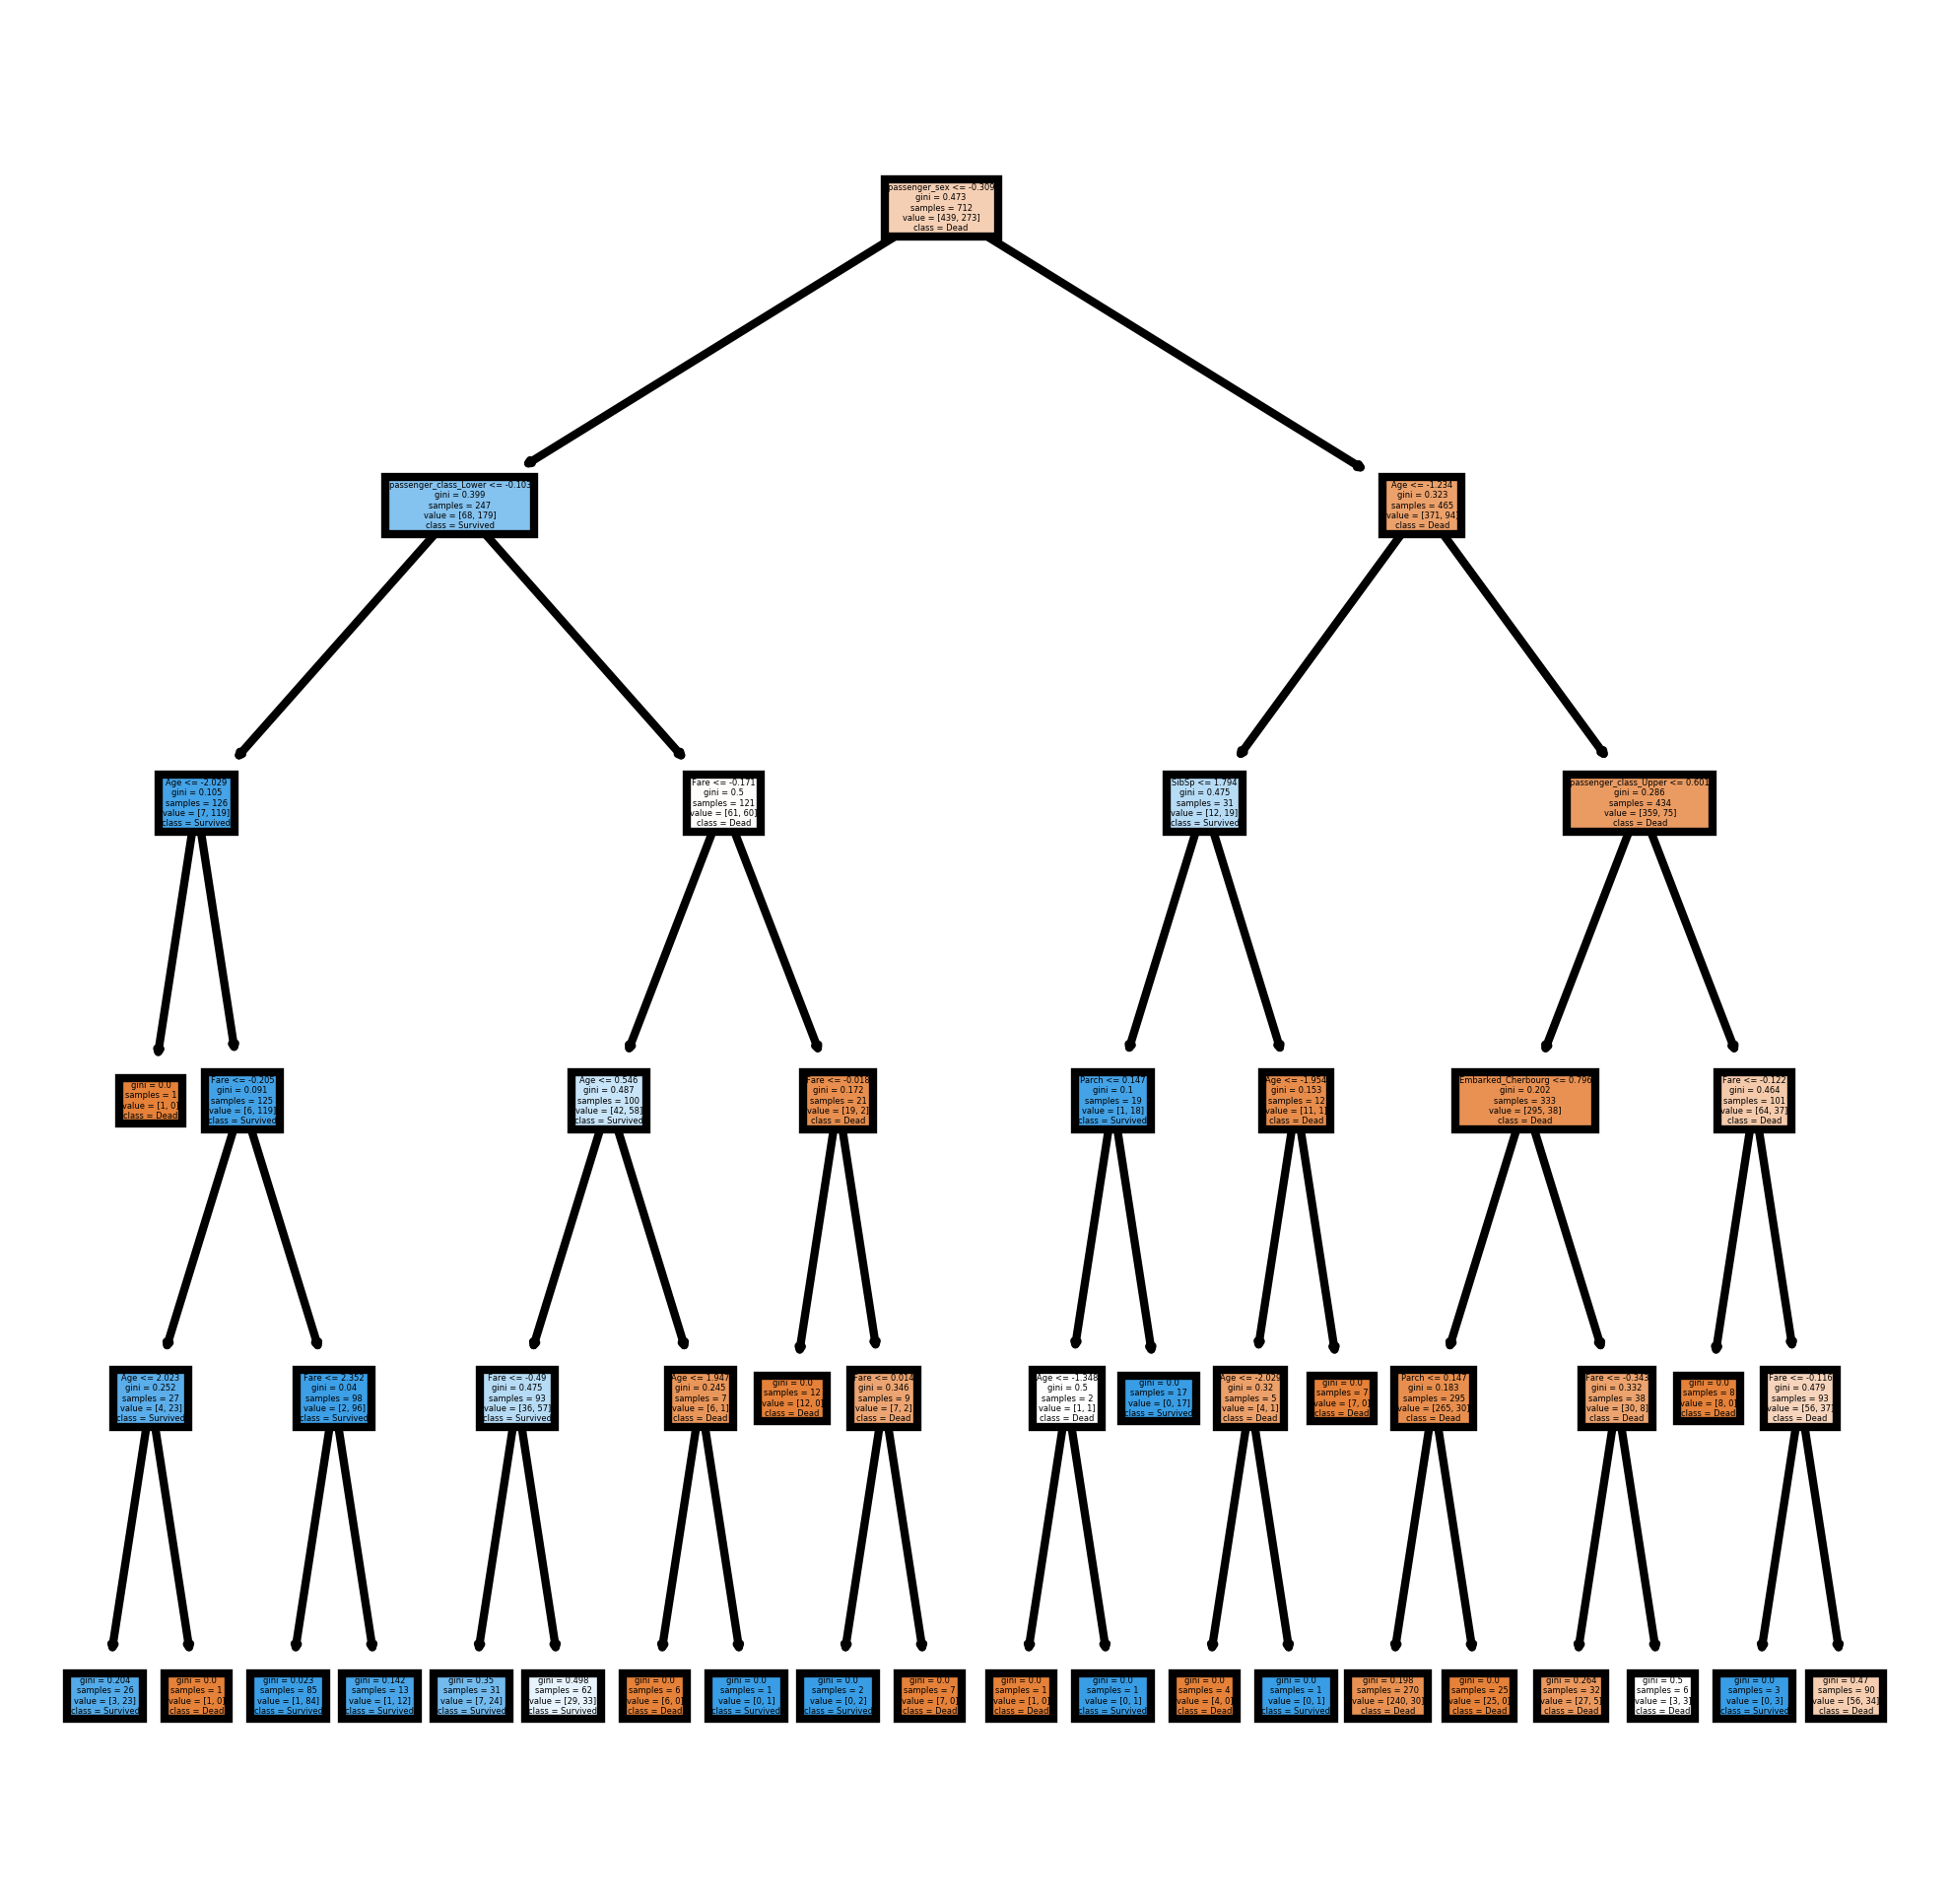

#######################################################
              Prueba Observacion 9                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


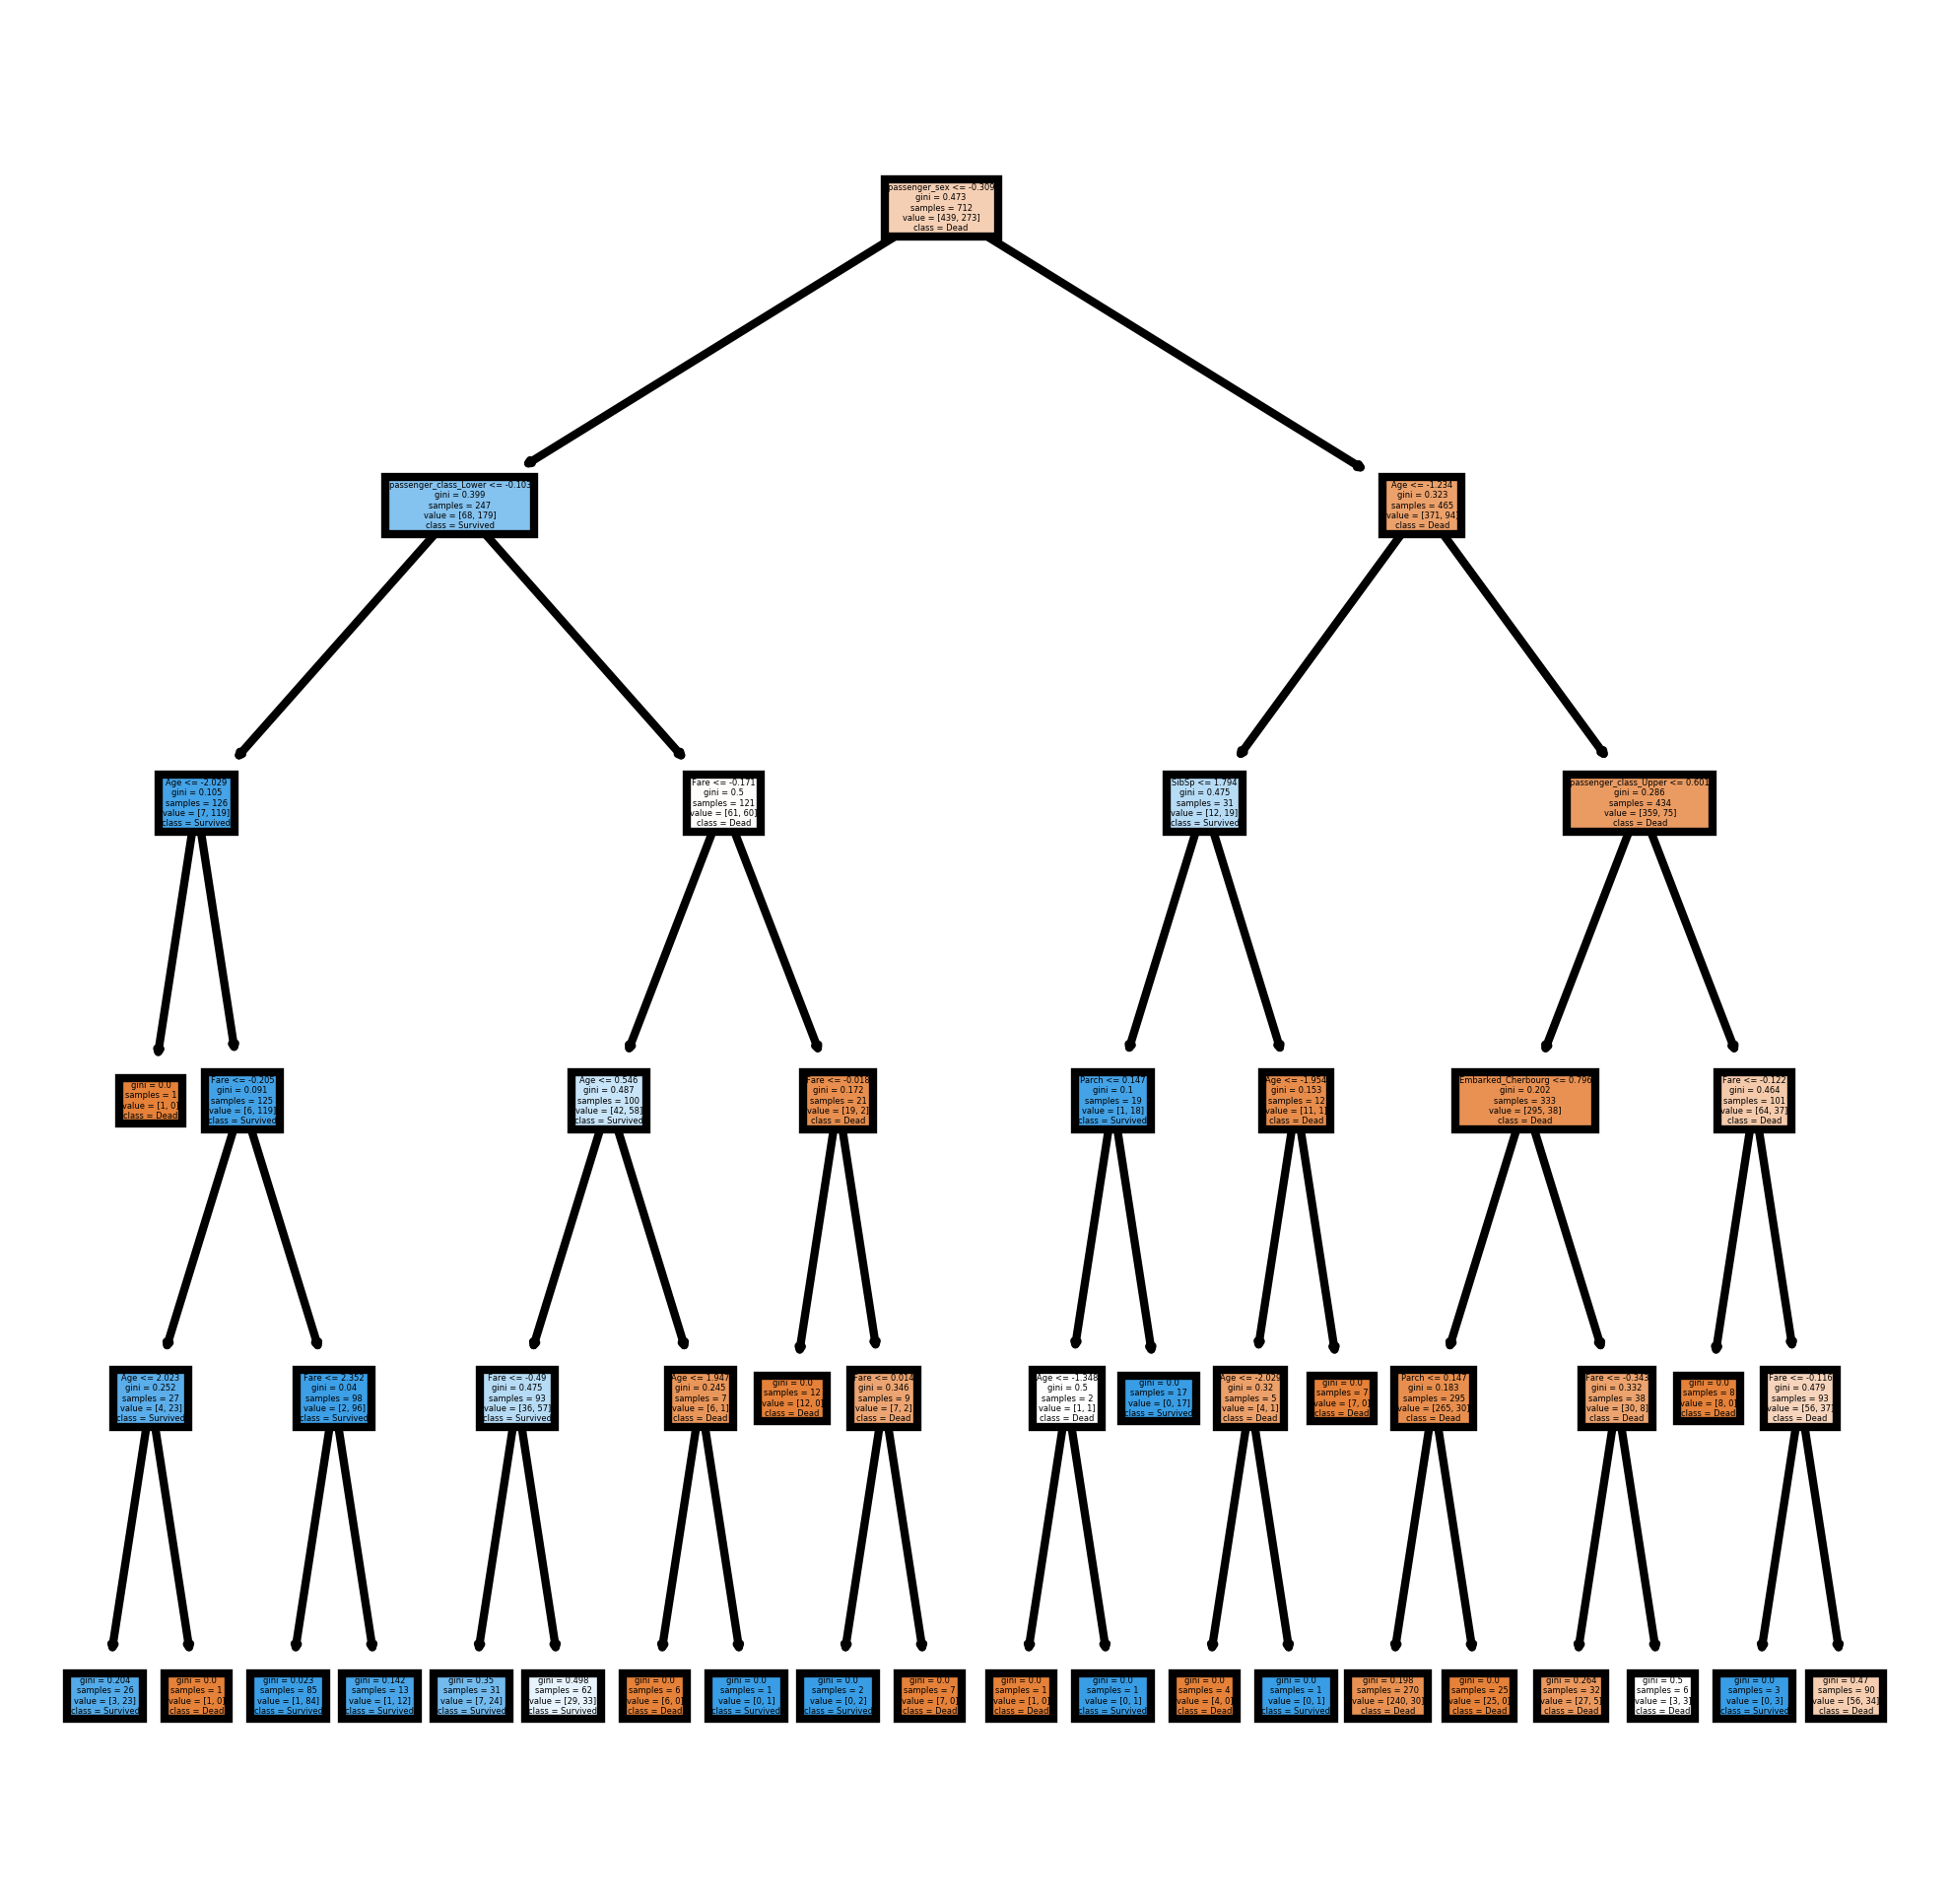

#######################################################
              Prueba Observacion 10                    
#######################################################
Como referencia el Y Real es: [1]
La predicción para esta observación es:[1.]
La predicción probabilistica con el Metodo Naive Bayes es:[[0.51240664 0.48759336]]
La predicción probabilistica con Regresión Logistica es:[[0.8544236]]
Se imprime el arbol de decisión


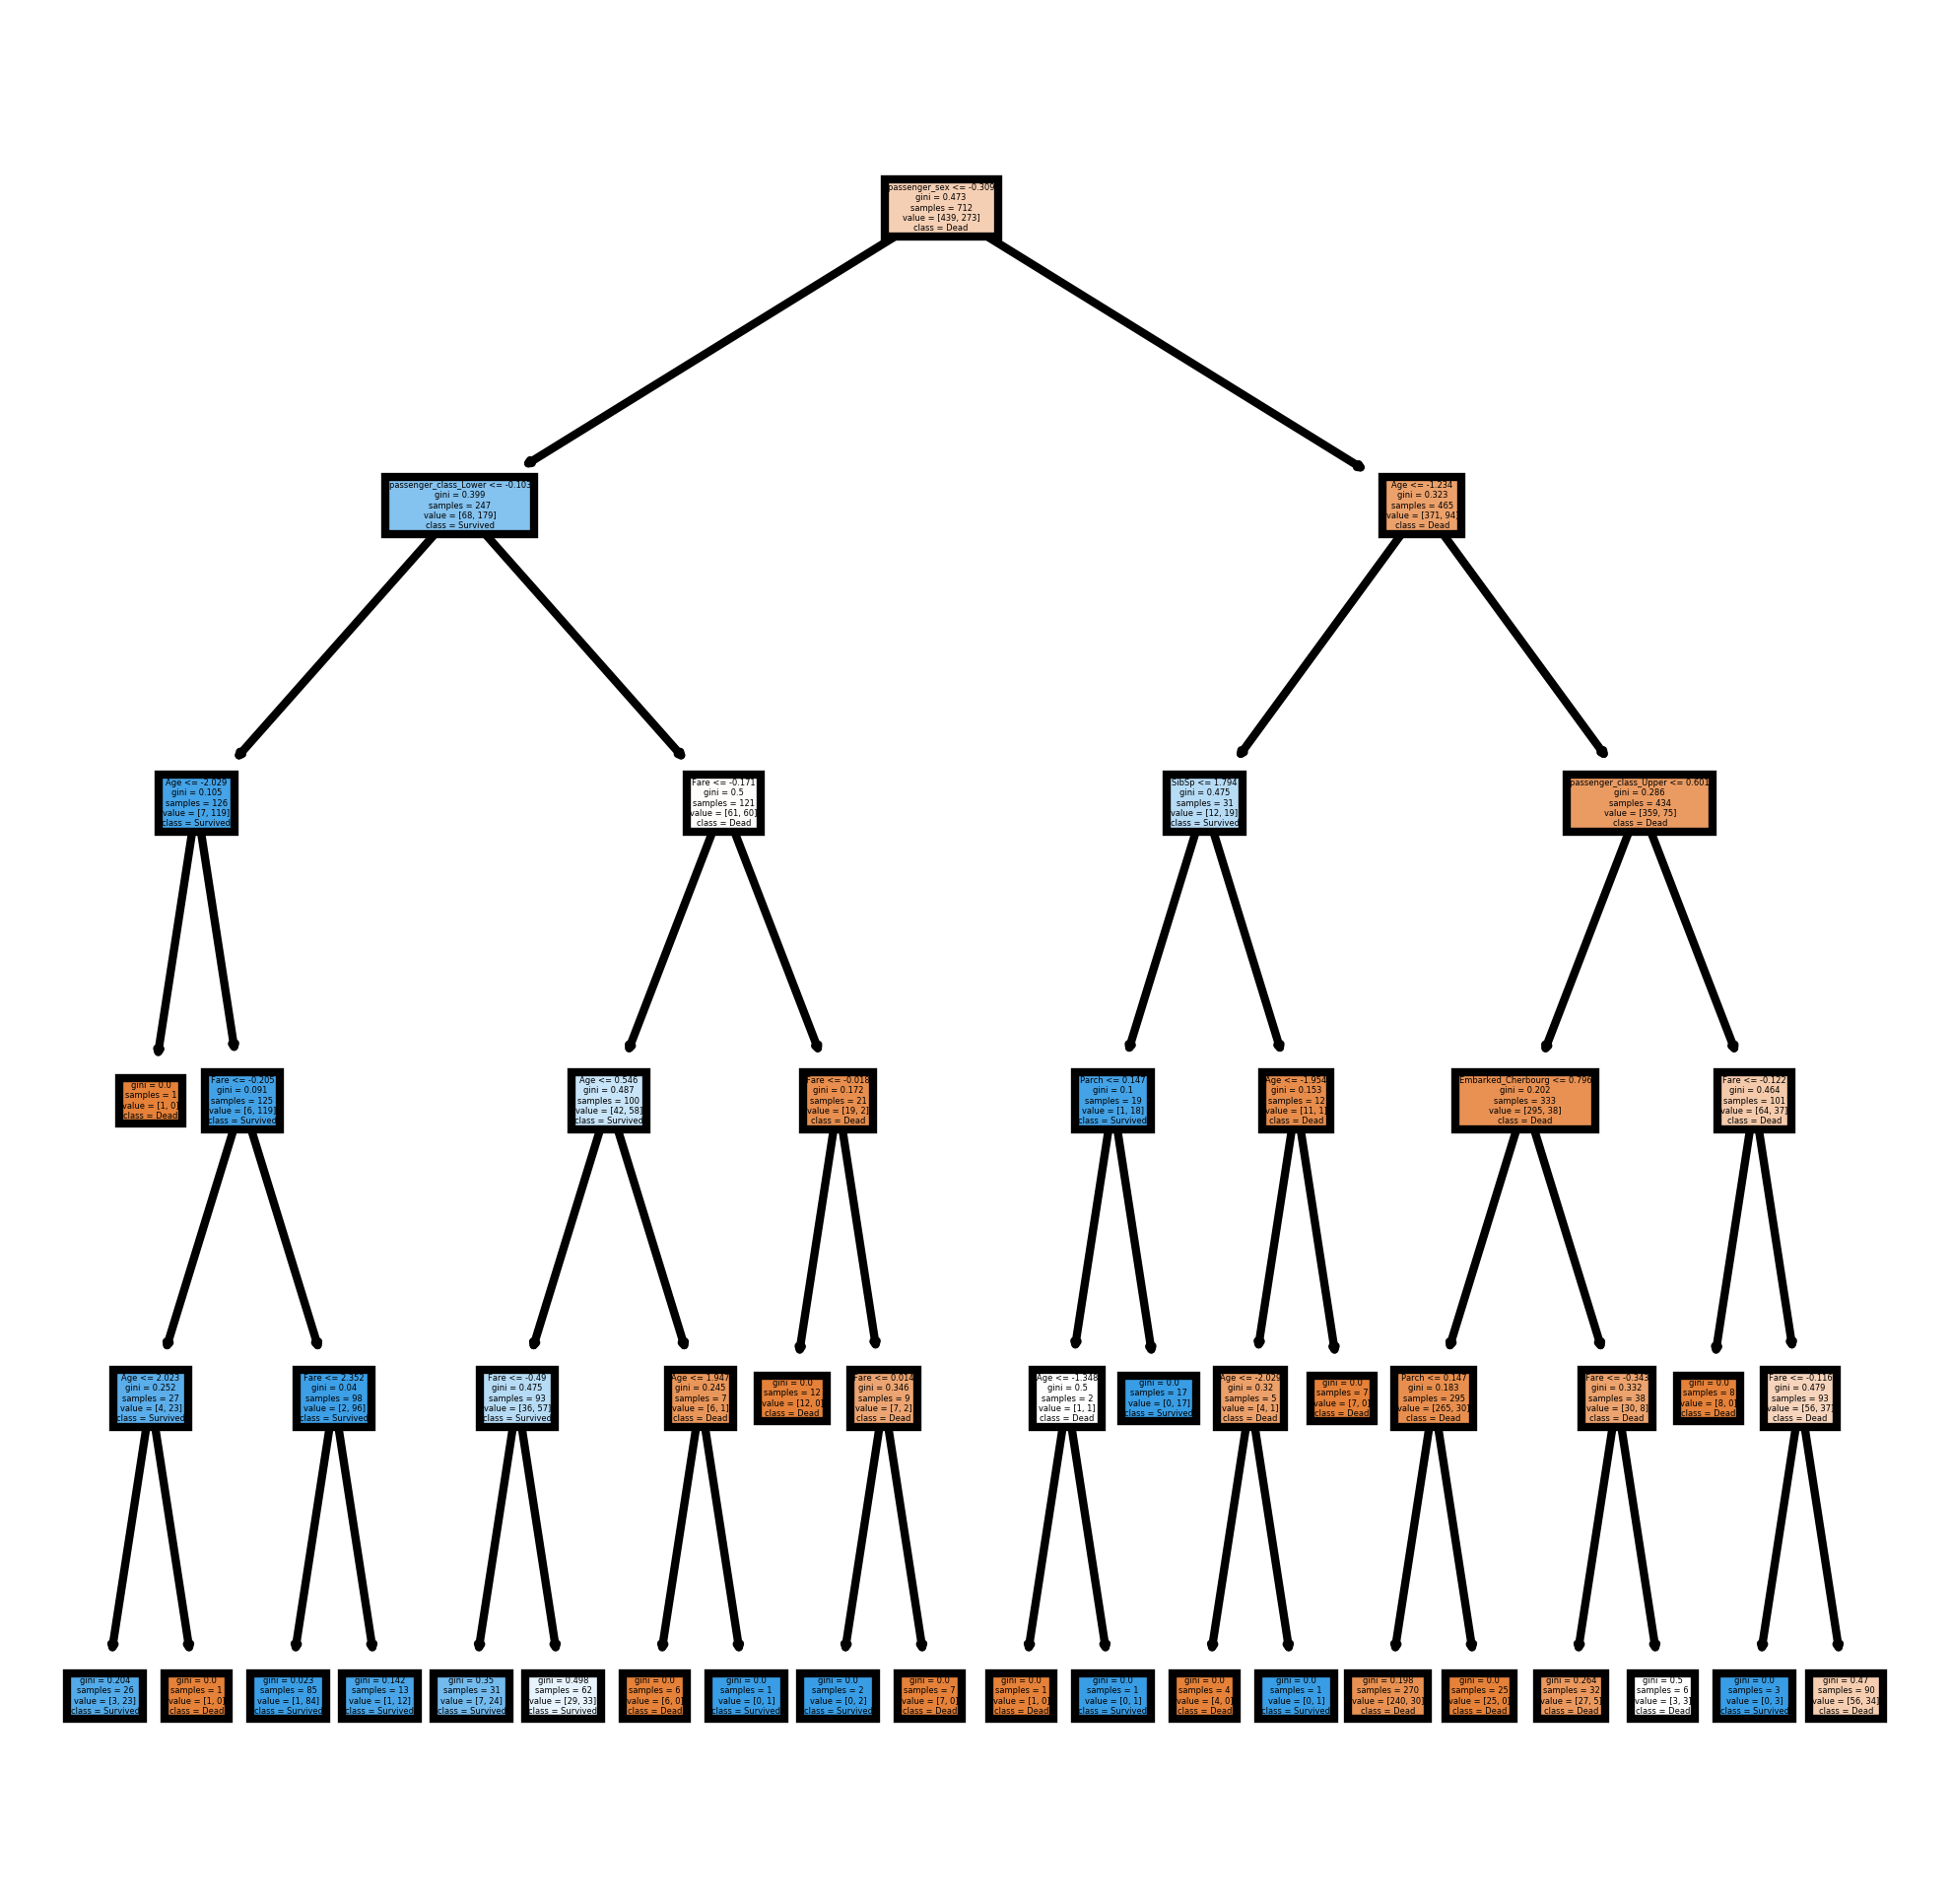

In [99]:
for i in range(len(X_samples)):
    print("#######################################################")
    print("              Prueba Observacion {}                    ".format(i+1))
    print("#######################################################")
    print("Como referencia el Y Real es: {}".format(Y_samples[9]))
    pred=prediccionObservacion(X_samples[9].reshape(1,-1))